<a href="https://colab.research.google.com/github/MilerDiazZevallos/Arequipa-Covid-19/blob/master/Sala_Situacional_Arequipa_SINADEF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initialize Environment

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
from scipy.optimize import curve_fit
import matplotlib.dates as mdates
import matplotlib.cbook as cbook

# Load Data from SINADEF

In [ ]:
import requests 

def download_url(url, save_path, chunk_size=128):
    r = requests.get(url, stream=True)
    with open(save_path, 'wb') as fd:
        for chunk in r.iter_content(chunk_size=chunk_size):
            fd.write(chunk)

In [ ]:
url_sinadef="SINADEF_DATOS_ABIERTOS_25032021.xlsx"
download_url("https://cloud.minsa.gob.pe/s/NctBnHXDnocgWAg/download?path=%2F&files="+url_sinadef, url_sinadef)

In [ ]:
SINADEF_File="fallecidos_sinadef.csv"
download_url("https://cloud.minsa.gob.pe/s/nqF2irNbFomCLaa/download",SINADEF_File) 
datos_SINADEF = pd.read_csv(SINADEF_File, encoding = "ISO-8859-1", sep=";")

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,3,13,14) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
datos_sinadef_old = pd.read_excel(url_sinadef, sheet_name='Tabla_SINADEF', skiprows=range(3), skipfooter=0)

In [ ]:
datos_sinadef_old.tail()

,Nº,TIPO SEGURO,SEXO,EDAD,TIEMPO EDAD,ESTADO CIVIL,NIVEL DE INSTRUCCIÓN,COD# UBIGEO DOMICILIO,PAIS DOMICILIO,DEPARTAMENTO DOMICILIO,PROVINCIA DOMICILIO,DISTRITO DOMICILIO,FECHA,AÑO,MES,TIPO LUGAR,INSTITUCION,MUERTE VIOLENTA,NECROPSIA,DEBIDO A (CAUSA A),CAUSA A (CIE-X),DEBIDO A (CAUSA B),CAUSA B (CIE-X),DEBIDO A (CAUSA C),CAUSA C (CIE-X),DEBIDO A (CAUSA D),CAUSA D (CIE-X),DEBIDO A (CAUSA E),CAUSA E (CIE-X),DEBIDO A (CAUSA F),CAUSA F (CIE-X)
616540,616541,SIS,FEMENINO,59,AÑOS,SOLTERO,SECUNDARIA INCOMPLETA,92-33-14-06-13-000,PERU,LIMA,HUAROCHIRI,RICARDO PALMA,2021-03-01,2021,3,EESS,MINSA,SIN REGISTRO,NO SE REALIZÓ NECROPSIA,HIPOXEMIA REFRACTARIA,J960,INSUFICIENCIA RENAL AGUDA,N179,OBESIDAD,E662,COVID 19,U071,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO
616541,616542,ESSALUD,FEMENINO,64,AÑOS,CASADO,IGNORADO,92-33-24-01-05-000,PERU,CALLAO,CALLAO,LA PERLA,2021-03-01,2021,3,EESS,ESSALUD,SIN REGISTRO,NO SE REALIZÓ NECROPSIA,INSUFICIENCIA RESPIRATORIA AGUDA DE TIPO 1,SIN REGISTRO,NEUIMONIA ATIPICA,SIN REGISTRO,COVID 19 VIRUS IDENTIFICADO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO
616542,616543,ESSALUD,MASCULINO,64,AÑOS,CASADO,SUPERIOR UNIV. COMP.,92-33-10-01-07-000,PERU,ICA,ICA,SAN JOSE DE LOS MOLINOS,2021-03-01,2021,3,EESS,ESSALUD,SIN REGISTRO,NO SE REALIZÓ NECROPSIA,INSUFICIENCIA RESPIRAORIA AGUDA,J960,NEUMONIA DEBIDA A OTROS VIRUS,J128,COVID-19 VIRUS IDENTIFICADO,U071,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO
616543,616544,SIS,FEMENINO,76,AÑOS,SOLTERO,IGNORADO,92-33-02-03-05-000,PERU,ANCASH,BOLOGNESI,CAJACAY,2021-03-01,2021,3,EESS,MINSA,SIN REGISTRO,NO SE REALIZÓ NECROPSIA,INSUFICIENCIA RESPIRATORIA,J960,ACCIDENTE CEREBROVASCULAR,I634,NEUMONIA,J13X,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO
616544,616545,SANIDAD PNP,MASCULINO,58,AÑOS,CASADO,IGNORADO,92-33-14-01-08-000,PERU,LIMA,LIMA,CHORRILLOS,2021-03-01,2021,3,EESS,PRIVADO,SIN REGISTRO,NO SE REALIZÓ NECROPSIA,INSUFICIENCIA RESPIRATORIA AGUDA,J960,NEUMONIA VIRAL,J129,COVID 19,U071,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO


# Funciones Auxiliares

In [ ]:
mondays = [pd.to_datetime('2020-05-04'), pd.to_datetime('2020-05-11'), pd.to_datetime('2020-05-18'), pd.to_datetime('2020-05-25'), \
           pd.to_datetime('2020-06-01'), pd.to_datetime('2020-06-08'), pd.to_datetime('2020-06-15'), pd.to_datetime('2020-06-22'), pd.to_datetime('2020-06-29'), \
           pd.to_datetime('2020-07-06'), pd.to_datetime('2020-07-13'), pd.to_datetime('2020-07-20'), pd.to_datetime('2020-07-27'), \
           pd.to_datetime('2020-08-03'), pd.to_datetime('2020-08-10'), pd.to_datetime('2020-08-17'), pd.to_datetime('2020-08-24'),  pd.to_datetime('2020-08-31'), \
           pd.to_datetime('2020-09-07'), pd.to_datetime('2020-09-14'), pd.to_datetime('2020-09-21'), pd.to_datetime('2020-09-28'), \
           pd.to_datetime('2020-10-05'), pd.to_datetime('2020-10-12'), pd.to_datetime('2020-10-19'), pd.to_datetime('2020-10-26'), \
           pd.to_datetime('2020-11-02'), pd.to_datetime('2020-11-09'), pd.to_datetime('2020-11-16'), pd.to_datetime('2020-11-23'), pd.to_datetime('2020-11-30'), \
           pd.to_datetime('2020-12-07'), pd.to_datetime('2020-12-14'), pd.to_datetime('2020-12-21'), pd.to_datetime('2020-12-28'), \
           pd.to_datetime('2021-01-04'), pd.to_datetime('2021-01-11'), pd.to_datetime('2021-01-18'), pd.to_datetime('2021-01-25'), \
           pd.to_datetime('2021-02-01'), pd.to_datetime('2021-02-08'), pd.to_datetime('2021-02-15'), pd.to_datetime('2021-02-22'), \
           pd.to_datetime('2021-03-01'), pd.to_datetime('2021-03-08'), pd.to_datetime('2021-03-15'), pd.to_datetime('2021-03-22'), pd.to_datetime('2021-03-25')]

In [ ]:
# Every two weeks
mondays = [pd.to_datetime('2020-05-04'), pd.to_datetime('2020-05-18'), pd.to_datetime('2020-06-01'), pd.to_datetime('2020-06-15'), \
           pd.to_datetime('2020-06-29'), pd.to_datetime('2020-07-13'), pd.to_datetime('2020-07-27'), pd.to_datetime('2020-08-10'), \
           pd.to_datetime('2020-08-24'), pd.to_datetime('2020-09-07'), pd.to_datetime('2020-09-21'), pd.to_datetime('2020-10-05'), \
           pd.to_datetime('2020-10-19'), pd.to_datetime('2020-11-02'), pd.to_datetime('2020-11-16'), pd.to_datetime('2020-11-30'), \
           pd.to_datetime('2020-12-14'), pd.to_datetime('2020-12-28'), pd.to_datetime('2021-01-11'), pd.to_datetime('2021-01-25'), \
           pd.to_datetime('2021-02-08'), pd.to_datetime('2021-02-22'), pd.to_datetime('2021-03-08'), pd.to_datetime('2021-03-15'), \
           pd.to_datetime('2021-03-22'), pd.to_datetime('2021-03-25')]

In [ ]:
dia_semana_sinadef = '2021-03-21'
dia_sinadef = '2021-03-25'

In [ ]:
def plots(ax, type, data, labelx, labely, datax = '', datay = '', label = ''):
    if type == 'line_plt':
        ax.plot(data[datax],'--o',ms=10,label=labely)
        ax.plot(data[datax].rolling(7).mean(),'--o',ms=10,label=labely + ' promedio 7 días')
        ax.tick_params(labelsize=18)
        ax.set_xlabel(labelx,fontsize=28)
        #ax.set_xlim([pd.to_datetime('2020-11-01'),None])
    elif type == 'reg_sns':
        ax = sns.regplot(x=datax, y=datay, data=data, order=3, label=labely, ax=ax)
        ax.tick_params(labelsize=18)
        ax.set_xlabel(labelx,fontsize=28)
        ax.set_ylabel(labely,fontsize=28)
        #ax.set_xlim([pd.to_datetime('2020-09-01'),None])
    elif type == 'bar_sns':
        ax = sns.barplot(x=data.index, y=datay, data=data, ax=ax)
        ax.tick_params(labelsize=18)
        ax.set_xlabel(labelx,fontsize=28)
        ax.set_ylabel(labely,fontsize=28)
        #ax.set_xlim([pd.to_datetime('2020-09-01'),None])
    elif type == 'bar_stacked_plt':
        ax.bar(data.index, data[datay+'_positivos'], edgecolor='white', width=1, label=labely+' positivos')
        ax.bar(data.index, data[datay+'_sospechosos'], bottom=data[datay+'_positivos'], edgecolor='white', width=1, label=labely+' sospechosos')
        ax.tick_params(labelsize=18)
        ax.set_xlabel(labelx,fontsize=28)
        ax.set_ylabel(labely,fontsize=28)
        #ax.set_xlim([pd.to_datetime('2020-09-01'),None])
    elif type == 'bar_stacked_plt_uci':
        ax.bar(data.index, data[datay+'_positivos'], edgecolor='white', width=1, label=labely+' positivos')
        ax.bar(data.index, data[datay+'_sospechosos'], bottom=data[datay+'_positivos'], edgecolor='white', width=1, label=labely+' sospechosos')
        ax.bar(data.index, data['trauma_shock'], bottom=data[datay+'_positivos'] + data[datay+'_sospechosos'], edgecolor='white', width=1, label='trauma shock')
        ax.tick_params(labelsize=18)
        ax.set_xlabel(labelx,fontsize=28)
        ax.set_ylabel(labely,fontsize=28)
        #ax.set_xlim([pd.to_datetime('2020-09-01'),None])
    elif type == 'line_reg_stacked_sns':
        ax = sns.regplot(x=datax, y=datay+'_positivos', data=data, order=3, label=labely+' positivos', ax=ax)
        ax = sns.regplot(x=datax, y=datay+'_sospechosos', data=data, order=3, label=labely+' sospechosos', ax=ax)
        ax.tick_params(labelsize=18)
        ax.set_xlabel(labelx,fontsize=28)
        ax.set_ylabel(labely,fontsize=28)
        #ax.set_xlim([pd.to_datetime('2020-09-01'),None])
    ax.legend(fontsize=20)

# Pre-procesamiento

In [ ]:
datos_sinadef_old.sort_values('FECHA').tail()

,Nº,TIPO SEGURO,SEXO,EDAD,TIEMPO EDAD,ESTADO CIVIL,NIVEL DE INSTRUCCIÓN,COD# UBIGEO DOMICILIO,PAIS DOMICILIO,DEPARTAMENTO DOMICILIO,PROVINCIA DOMICILIO,DISTRITO DOMICILIO,FECHA,AÑO,MES,TIPO LUGAR,INSTITUCION,MUERTE VIOLENTA,NECROPSIA,DEBIDO A (CAUSA A),CAUSA A (CIE-X),DEBIDO A (CAUSA B),CAUSA B (CIE-X),DEBIDO A (CAUSA C),CAUSA C (CIE-X),DEBIDO A (CAUSA D),CAUSA D (CIE-X),DEBIDO A (CAUSA E),CAUSA E (CIE-X),DEBIDO A (CAUSA F),CAUSA F (CIE-X)
592363,592364,SIS,MASCULINO,61,AÑOS,SOLTERO,IGNORADO,92-33-12-01-11-000,PERU,LA LIBERTAD,TRUJILLO,LA ESPERANZA,2021-03-25,2021,3,EESS,GOBIERNO REGIONAL,SIN REGISTRO,NO SE REALIZÓ NECROPSIA,SINDROME DE DISTRES RESPIRATORIO,J80X,SEPSIS PUNTO RESPIRATORIO,A419,INFECCION POR CORONAVIRUS,B972,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO
592362,592363,IGNORADO,MASCULINO,56,AÑOS,CASADO,SECUNDARIA COMPLETA,92-33-14-01-08-000,PERU,LIMA,LIMA,CHORRILLOS,2021-03-25,2021,3,OTRO,SIN REGISTRO,SIN REGISTRO,NO SE REALIZÓ NECROPSIA,SHOCK SEPTICO REFRACTARIO,A419,INSUFICIENCIA RESPIRATORIA,J969,DIABETES MELLITUS,E119,NEUMONIA VIRAL POR COVID 19,U071,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO
592360,592361,ESSALUD,FEMENINO,50,AÑOS,CASADO,SECUNDARIA COMPLETA,92-33-14-01-37-000,PERU,LIMA,LIMA,SAN JUAN DE LURIGANCHO,2021-03-25,2021,3,DOMICILIO,SIN REGISTRO,SIN REGISTRO,NO SE REALIZÓ NECROPSIA,SEPSIS,A419,CANCER DE CUELLO UTERINO,C539,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO
592352,592353,SIS,MASCULINO,52,AÑOS,CASADO,SECUNDARIA COMPLETA,92-33-14-01-09-000,PERU,LIMA,LIMA,LA VICTORIA,2021-03-25,2021,3,EESS,MINSA,SIN REGISTRO,NO SE REALIZÓ NECROPSIA,INSUFICIENCIA RESPIRATORIA,J960,INFECCION COVID,U071,NEUMONIA,J189,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO
592685,592686,SIS,FEMENINO,106,AÑOS,VIUDO,IGNORADO,92-33-05-01-01-000,PERU,AYACUCHO,HUAMANGA,AYACUCHO,2021-03-25,2021,3,EESS,GOBIERNO REGIONAL,SIN REGISTRO,NO SE REALIZÓ NECROPSIA,SINDROME DE DISTRES RESPIRATORIO AGUDO,J80X,NEUMONIA ATIPICA VIRAL,J128,COVID19,U071,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO


In [ ]:
datos_sinadef_raw = datos_sinadef_old.copy()

In [ ]:
datos_sinadef_raw['SEMANA'] = pd.to_datetime(datos_sinadef_raw['FECHA']).dt.week
datos_sinadef_raw['AÑOSEMANA'] = pd.to_datetime(datos_sinadef_raw['FECHA']).dt.strftime('%Y') + '-' + datos_sinadef_raw['SEMANA'].astype(str)
datos_sinadef_raw['MESDIA'] = pd.to_datetime(datos_sinadef_raw['FECHA']).dt.strftime('%m-%d')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  """Entry point for launching an IPython kernel.


In [ ]:
datos_sinadef_raw = datos_sinadef_raw[datos_sinadef_raw.FECHA != '2017-01-01']

datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2018-12-31', 'AÑOSEMANA'] = '2019-1'

datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2019-12-30', 'AÑOSEMANA'] = '2020-1'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2019-12-31', 'AÑOSEMANA'] = '2020-1'

datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2020-12-28', 'AÑOSEMANA'] = '2021-1'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2020-12-29', 'AÑOSEMANA'] = '2021-1'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2020-12-30', 'AÑOSEMANA'] = '2021-1'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2020-12-31', 'AÑOSEMANA'] = '2021-1'

datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-01-01', 'AÑOSEMANA'] = '2021-1'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-01-02', 'AÑOSEMANA'] = '2021-1'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-01-03', 'AÑOSEMANA'] = '2021-1'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-01-04', 'AÑOSEMANA'] = '2021-2'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-01-05', 'AÑOSEMANA'] = '2021-2'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-01-06', 'AÑOSEMANA'] = '2021-2'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-01-07', 'AÑOSEMANA'] = '2021-2'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-01-08', 'AÑOSEMANA'] = '2021-2'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-01-09', 'AÑOSEMANA'] = '2021-2'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-01-10', 'AÑOSEMANA'] = '2021-2'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-01-11', 'AÑOSEMANA'] = '2021-3'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-01-12', 'AÑOSEMANA'] = '2021-3'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-01-13', 'AÑOSEMANA'] = '2021-3'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-01-14', 'AÑOSEMANA'] = '2021-3'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-01-15', 'AÑOSEMANA'] = '2021-3'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-01-16', 'AÑOSEMANA'] = '2021-3'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-01-17', 'AÑOSEMANA'] = '2021-3'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-01-18', 'AÑOSEMANA'] = '2021-4'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-01-19', 'AÑOSEMANA'] = '2021-4'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-01-20', 'AÑOSEMANA'] = '2021-4'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-01-21', 'AÑOSEMANA'] = '2021-4'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-01-22', 'AÑOSEMANA'] = '2021-4'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-01-23', 'AÑOSEMANA'] = '2021-4'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-01-24', 'AÑOSEMANA'] = '2021-4'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-01-25', 'AÑOSEMANA'] = '2021-5'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-01-26', 'AÑOSEMANA'] = '2021-5'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-01-27', 'AÑOSEMANA'] = '2021-5'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-01-28', 'AÑOSEMANA'] = '2021-5'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-01-29', 'AÑOSEMANA'] = '2021-5'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-01-30', 'AÑOSEMANA'] = '2021-5'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-01-31', 'AÑOSEMANA'] = '2021-5'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-02-01', 'AÑOSEMANA'] = '2021-6'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-02-02', 'AÑOSEMANA'] = '2021-6'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-02-03', 'AÑOSEMANA'] = '2021-6'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-02-04', 'AÑOSEMANA'] = '2021-6'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-02-05', 'AÑOSEMANA'] = '2021-6'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-02-06', 'AÑOSEMANA'] = '2021-6'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-02-07', 'AÑOSEMANA'] = '2021-6'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-02-08', 'AÑOSEMANA'] = '2021-7'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-02-09', 'AÑOSEMANA'] = '2021-7'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-02-10', 'AÑOSEMANA'] = '2021-7'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-02-11', 'AÑOSEMANA'] = '2021-7'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-02-12', 'AÑOSEMANA'] = '2021-7'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-02-13', 'AÑOSEMANA'] = '2021-7'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-02-14', 'AÑOSEMANA'] = '2021-7'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-02-15', 'AÑOSEMANA'] = '2021-8'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-02-16', 'AÑOSEMANA'] = '2021-8'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-02-17', 'AÑOSEMANA'] = '2021-8'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-02-18', 'AÑOSEMANA'] = '2021-8'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-02-19', 'AÑOSEMANA'] = '2021-8'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-02-20', 'AÑOSEMANA'] = '2021-8'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-02-21', 'AÑOSEMANA'] = '2021-8'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-02-22', 'AÑOSEMANA'] = '2021-9'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-02-23', 'AÑOSEMANA'] = '2021-9'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-02-24', 'AÑOSEMANA'] = '2021-9'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-02-25', 'AÑOSEMANA'] = '2021-9'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-02-26', 'AÑOSEMANA'] = '2021-9'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-02-27', 'AÑOSEMANA'] = '2021-9'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-02-28', 'AÑOSEMANA'] = '2021-9'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-03-01', 'AÑOSEMANA'] = '2021-10'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-03-02', 'AÑOSEMANA'] = '2021-10'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-03-03', 'AÑOSEMANA'] = '2021-10'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-03-04', 'AÑOSEMANA'] = '2021-10'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-03-05', 'AÑOSEMANA'] = '2021-10'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-03-06', 'AÑOSEMANA'] = '2021-10'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-03-07', 'AÑOSEMANA'] = '2021-10'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-03-08', 'AÑOSEMANA'] = '2021-11'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-03-09', 'AÑOSEMANA'] = '2021-11'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-03-10', 'AÑOSEMANA'] = '2021-11'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-03-11', 'AÑOSEMANA'] = '2021-11'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-03-12', 'AÑOSEMANA'] = '2021-11'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-03-13', 'AÑOSEMANA'] = '2021-11'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-03-14', 'AÑOSEMANA'] = '2021-11'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-03-15', 'AÑOSEMANA'] = '2021-12'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-03-16', 'AÑOSEMANA'] = '2021-12'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-03-17', 'AÑOSEMANA'] = '2021-12'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-03-18', 'AÑOSEMANA'] = '2021-12'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-03-19', 'AÑOSEMANA'] = '2021-12'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-03-20', 'AÑOSEMANA'] = '2021-12'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-03-21', 'AÑOSEMANA'] = '2021-12'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-03-22', 'AÑOSEMANA'] = '2021-13'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-03-23', 'AÑOSEMANA'] = '2021-13'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-03-24', 'AÑOSEMANA'] = '2021-13'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-03-25', 'AÑOSEMANA'] = '2021-13'

In [ ]:
new = datos_sinadef_raw["AÑOSEMANA"].str.split("-", n = 1, expand = True) 
datos_sinadef_raw["AÑO2"]= new[0].astype(int)
datos_sinadef_raw["SEMANA"]= new[1].astype(int)

# Visualizaciones Peru, Semanales y Diarias

In [ ]:
datos_sinadef_semana = datos_sinadef_raw[datos_sinadef_raw['FECHA'] <= dia_semana_sinadef ]
datos_sinadef_semana = datos_sinadef_semana.groupby(['SEMANA', 'AÑO2'])['Nº'].count()
datos_sinadef_semana = datos_sinadef_semana.to_frame().reset_index()
datos_sinadef_semana.sort_values(['AÑO2', 'SEMANA'])

,SEMANA,AÑO2,Nº
0,1,2017,1584
5,2,2017,1671
10,3,2017,1739
15,4,2017,1761
20,5,2017,1880
...,...,...,...
39,8,2021,7657
44,9,2021,7341
49,10,2021,7337
54,11,2021,7234


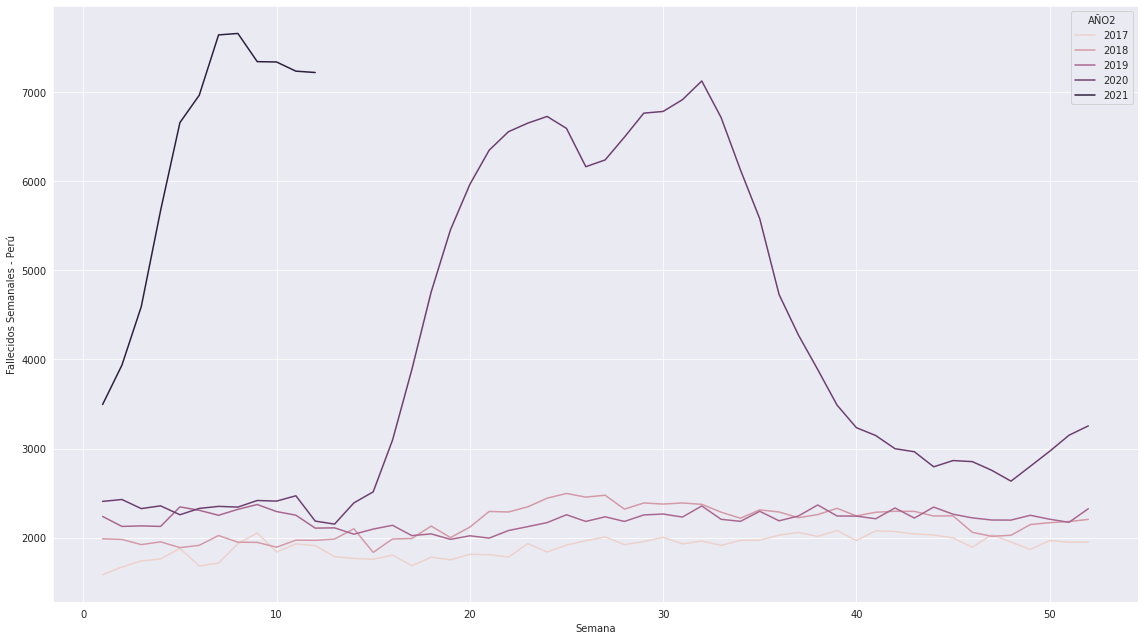

In [ ]:
fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(16, 9))

sns.lineplot(data=datos_sinadef_semana, x = 'SEMANA', y = 'Nº', hue='AÑO2', ax=ax1)

plt.xlabel('Semana')
plt.ylabel('Fallecidos Semanales - Perú')
fig.tight_layout()

plt.show()

In [ ]:
datos_sinadef_dia = datos_sinadef_raw[datos_sinadef_raw['FECHA'] <= dia_sinadef ]
datos_sinadef_dia = datos_sinadef_dia.groupby(['MESDIA', 'AÑO'])['Nº'].count()
datos_sinadef_dia = datos_sinadef_dia.to_frame().reset_index()
datos_sinadef_dia

,MESDIA,AÑO,Nº
0,01-01,2018,321
1,01-01,2019,345
2,01-01,2020,378
3,01-01,2021,513
4,01-02,2017,238
...,...,...,...
1539,12-30,2020,501
1540,12-31,2017,273
1541,12-31,2018,296
1542,12-31,2019,338


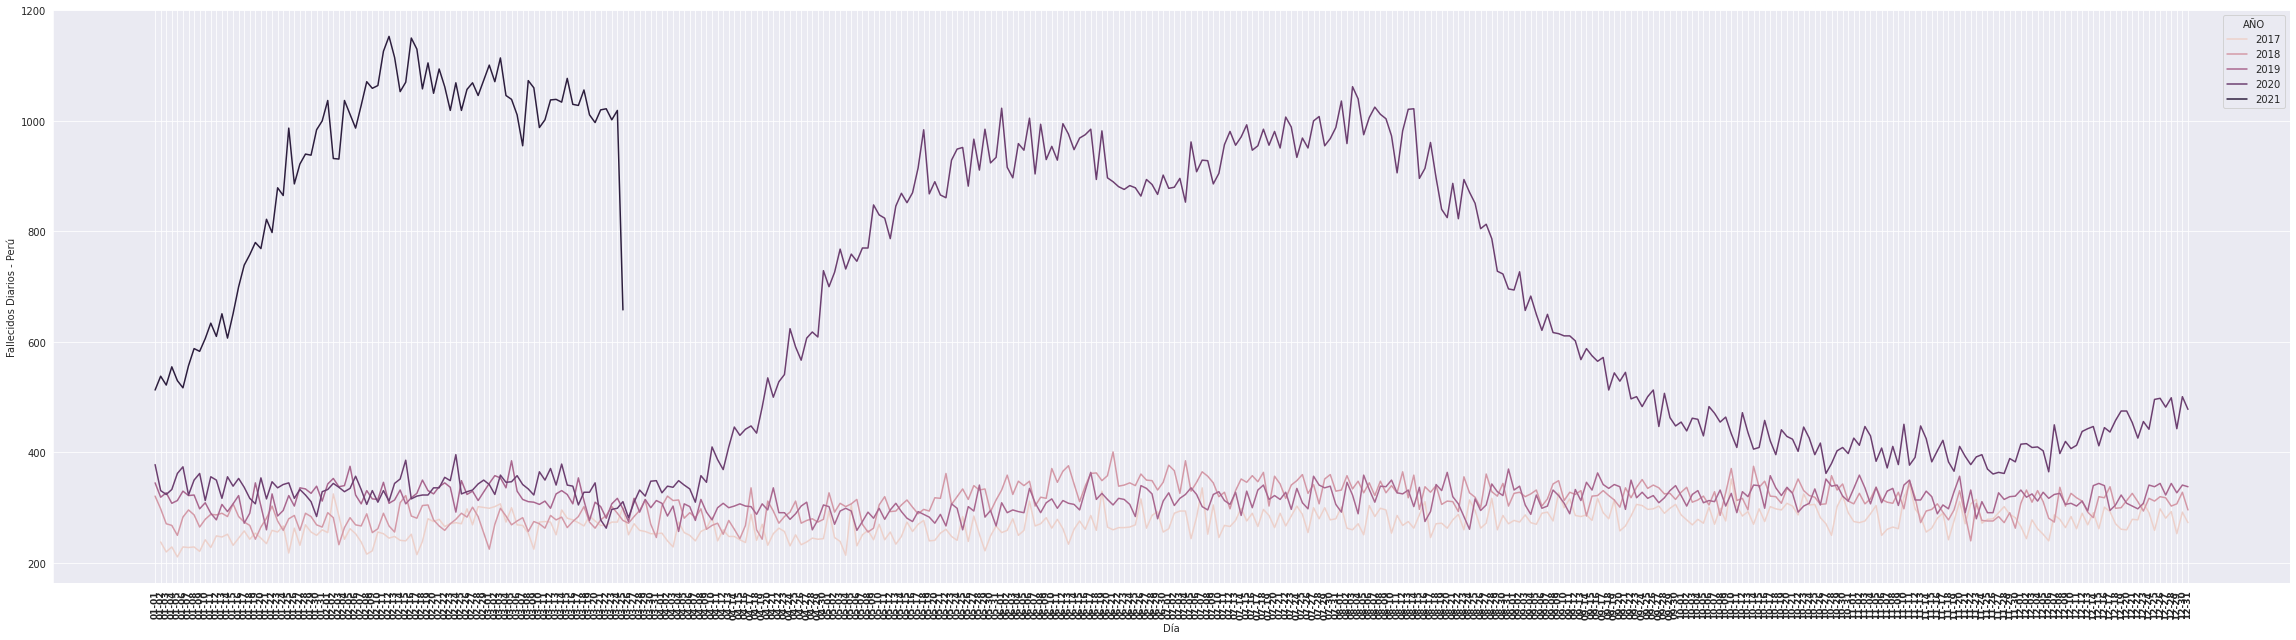

In [ ]:
fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(32, 9))

sns.lineplot(data=datos_sinadef_dia, x = 'MESDIA', y = 'Nº', hue='AÑO', ax=ax1)

plt.xlabel('Día')
plt.ylabel('Fallecidos Diarios - Perú')
plt.xticks(rotation=90, fontsize=9, fontweight='bold')
fig.tight_layout()

plt.savefig('SINADEF_Anual.pdf')
plt.show()

In [ ]:
datos_sinadef_departamentos = datos_sinadef_raw[datos_sinadef_raw['FECHA'] <= dia_semana_sinadef ]
datos_sinadef_departamentos = datos_sinadef_departamentos.groupby(['DEPARTAMENTO DOMICILIO', 'AÑO2', 'SEMANA'])['Nº'].count()
datos_sinadef_departamentos = datos_sinadef_departamentos.to_frame()
datos_sinadef_departamentos.columns = ['real']
datos_sinadef_departamentos

real
DEPARTAMENTO DOMICILIO AÑO2 SEMANA      
AMAZONAS               2017 1         11
                            2         13
                            3         16
                            4          9
                            5         17
...                                  ...
UCAYALI                2021 8         81
                            9         65
                            10        56
                            11        75
                            12        88

[5929 rows x 1 columns]

In [ ]:
def plot_sinadef_departamentos(result, ax, state_name):
    ax.set_title(f"{state_name}")

    #index = pd.to_datetime(result['real'].index.get_level_values('SEMANA'))
    index = result['real'].index.get_level_values('SEMANA')
    
    sns.lineplot(data=result, x = index , y = 'real', hue=result['real'].index.get_level_values('AÑO2'), ax=ax)
    #sns.lineplot(data=result, x = index , y = 'real', ax=ax)

def plot_rt_states():
    N_COLS = 2
    N_ROWS = int(np.ceil(len(datos_sinadef_raw['DEPARTAMENTO DOMICILIO'].unique()) / N_COLS))

    fig, axes = plt.subplots(nrows=N_ROWS, ncols=N_COLS, figsize=(24, N_ROWS*3), dpi=90)
    
    # loop for several states
    for i, (state_name, result) in enumerate(datos_sinadef_departamentos.groupby('DEPARTAMENTO DOMICILIO')):
        plot_sinadef_departamentos(result, axes.flat[i], state_name)

    # saving figure
    fig.tight_layout()
    fig.set_facecolor('w')

    plt.savefig('SINADEF_COVID_Regiones_01.pdf')

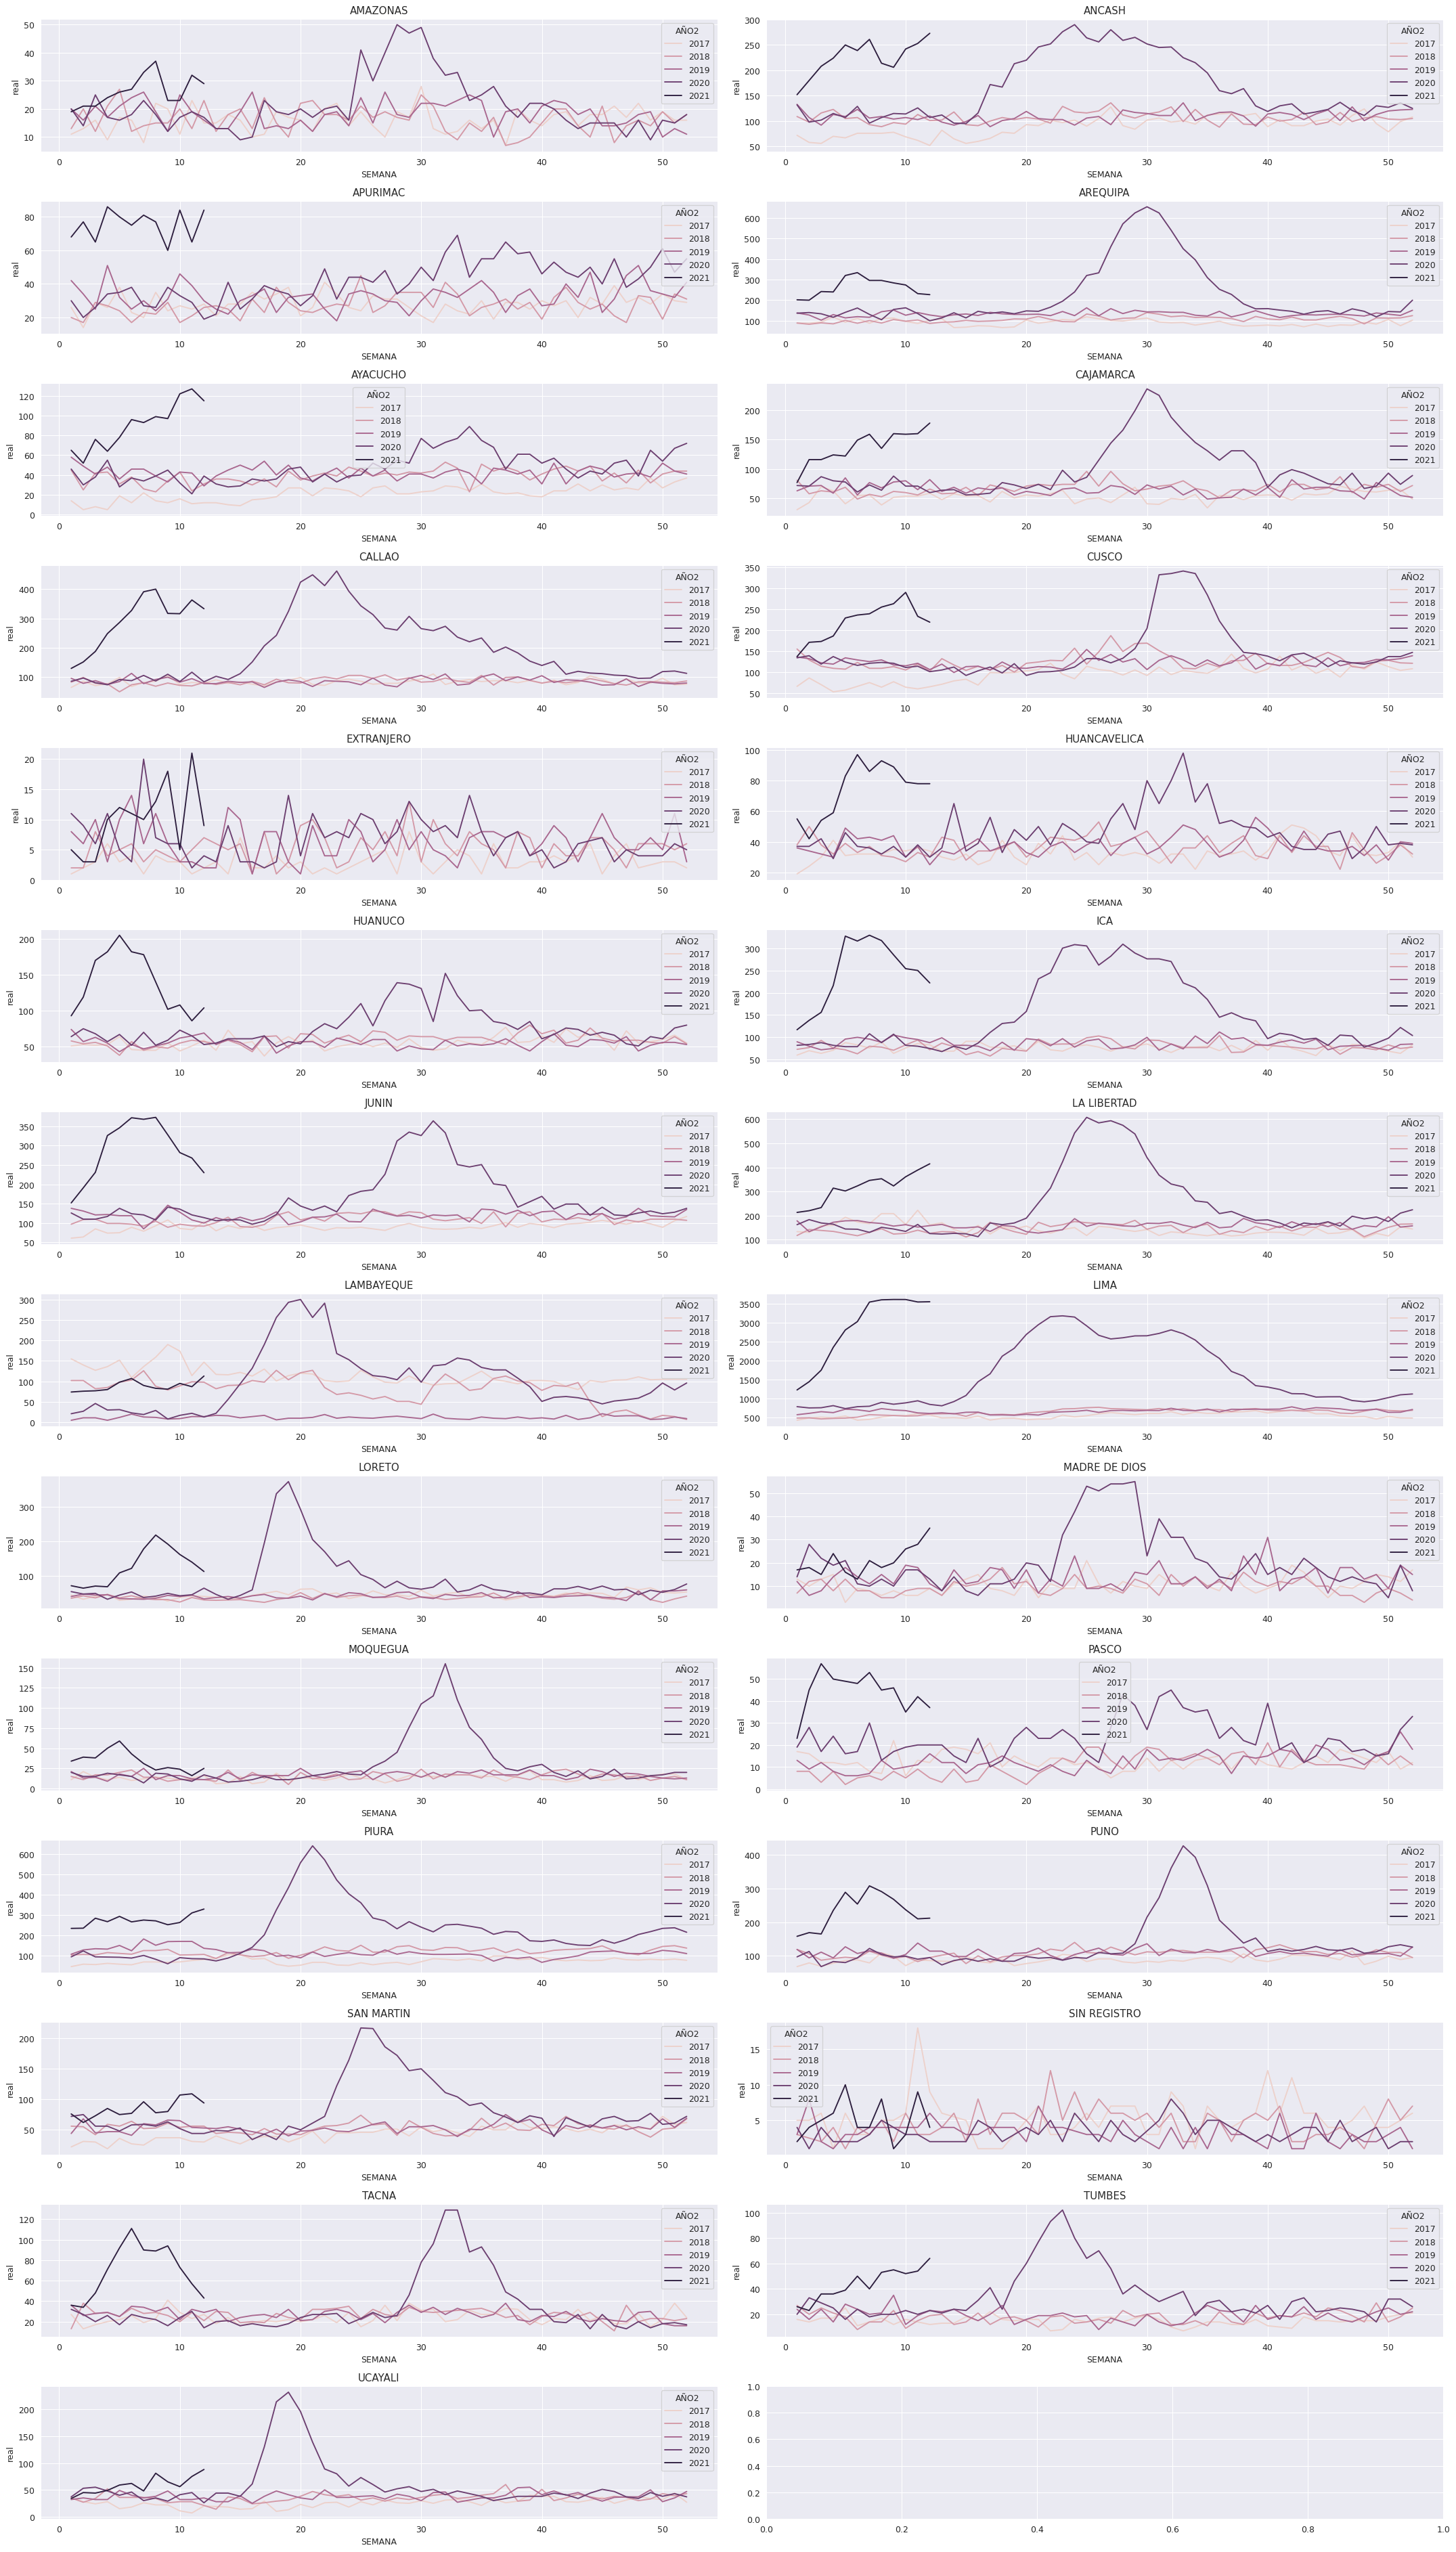

In [ ]:
plot_rt_states()

# Visualizaciones Arequipa, Semanales

In [ ]:
datos_sinadef_no_violenta = datos_sinadef_raw[datos_sinadef_raw['FECHA'] <= dia_semana_sinadef ]
#datos_sinadef_no_violenta = datos_sinadef_no_violenta[(datos_sinadef_no_violenta['MUERTE VIOLENTA'] == 'SIN REGISTRO')]

datos_sinadef_arequipa = datos_sinadef_no_violenta[datos_sinadef_no_violenta['DEPARTAMENTO DOMICILIO'] == 'AREQUIPA']
datos_sinadef_arequipa['DIASEMANA'] = pd.to_datetime(datos_sinadef_arequipa['FECHA']).dt.weekday
datos_sinadef_arequipa = datos_sinadef_arequipa.reset_index(drop=True)
datos_sinadef_arequipa.tail()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,Nº,TIPO SEGURO,SEXO,EDAD,TIEMPO EDAD,ESTADO CIVIL,NIVEL DE INSTRUCCIÓN,COD# UBIGEO DOMICILIO,PAIS DOMICILIO,DEPARTAMENTO DOMICILIO,PROVINCIA DOMICILIO,DISTRITO DOMICILIO,FECHA,AÑO,MES,TIPO LUGAR,INSTITUCION,MUERTE VIOLENTA,NECROPSIA,DEBIDO A (CAUSA A),CAUSA A (CIE-X),DEBIDO A (CAUSA B),CAUSA B (CIE-X),DEBIDO A (CAUSA C),CAUSA C (CIE-X),DEBIDO A (CAUSA D),CAUSA D (CIE-X),DEBIDO A (CAUSA E),CAUSA E (CIE-X),DEBIDO A (CAUSA F),CAUSA F (CIE-X),SEMANA,AÑOSEMANA,MESDIA,AÑO2,DIASEMANA
31806,616483,SIS,MASCULINO,61,AÑOS,SOLTERO,IGNORADO,92-33-04-01-01-000,PERU,AREQUIPA,AREQUIPA,AREQUIPA,2021-03-01,2021,3,EESS,GOBIERNO REGIONAL,SIN REGISTRO,NO SE REALIZÓ NECROPSIA,INSUFICIENCIA RESPIRATORIA,J960,NEUMONIA POR SARS COV 2,U071,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,10,2021-10,03-01,2021,0
31807,616497,IGNORADO,FEMENINO,92,AÑOS,CASADO,PRIMARIA COMPLETA,92-33-04-01-26-000,PERU,AREQUIPA,AREQUIPA,MARIANO MELGAR,2021-03-01,2021,3,DOMICILIO,SIN REGISTRO,SIN REGISTRO,NO SE REALIZÓ NECROPSIA,SENILIDAD,R54X,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,10,2021-10,03-01,2021,0
31808,616502,IGNORADO,FEMENINO,82,AÑOS,SOLTERO,IGNORADO,92-33-04-01-02-000,PERU,AREQUIPA,AREQUIPA,CAYMA,2021-03-01,2021,3,DOMICILIO,SIN REGISTRO,SIN REGISTRO,NO SE REALIZÓ NECROPSIA,INSUFICIENCIA RESPIRATORIA AGUDA SEVERA,J969,COVID 19 GRAVE,U071,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,10,2021-10,03-01,2021,0
31809,616514,IGNORADO,FEMENINO,75,AÑOS,CASADO,PRIMARIA INCOMPLETA,92-33-04-01-03-000,PERU,AREQUIPA,AREQUIPA,CERRO COLORADO,2021-03-01,2021,3,DOMICILIO,SIN REGISTRO,SIN REGISTRO,NO SE REALIZÓ NECROPSIA,FALLA MULTIORGANICA,R688,NEOPLASIA DE RIÑON,C64X,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,10,2021-10,03-01,2021,0
31810,616526,ESSALUD,FEMENINO,78,AÑOS,CASADO,IGNORADO,92-33-04-01-29-000,PERU,AREQUIPA,AREQUIPA,JOSE LUIS BUSTAMANTE Y RIVERO,2021-03-01,2021,3,EESS,ESSALUD,SIN REGISTRO,NO SE REALIZÓ NECROPSIA,INSUFICIENCIA RESPIRATORIA AGUDA,J960,NEUMONIA SARS,J129,INFECCION POR SARS COV 2,U071,SIN REGISTRO,SIN REGISTRO,HIPERTENSION ARTERIAL,I10X,SIN REGISTRO,SIN REGISTRO,10,2021-10,03-01,2021,0


In [ ]:
datos_sinadef_arequipa_semana = datos_sinadef_arequipa.groupby(['SEMANA', 'AÑO2'])['Nº'].count()
datos_sinadef_arequipa_semana = datos_sinadef_arequipa_semana.to_frame().reset_index()
datos_sinadef_arequipa_semana.tail()

,SEMANA,AÑO2,Nº
215,51,2020,143
216,52,2017,103
217,52,2018,125
218,52,2019,151
219,52,2020,200


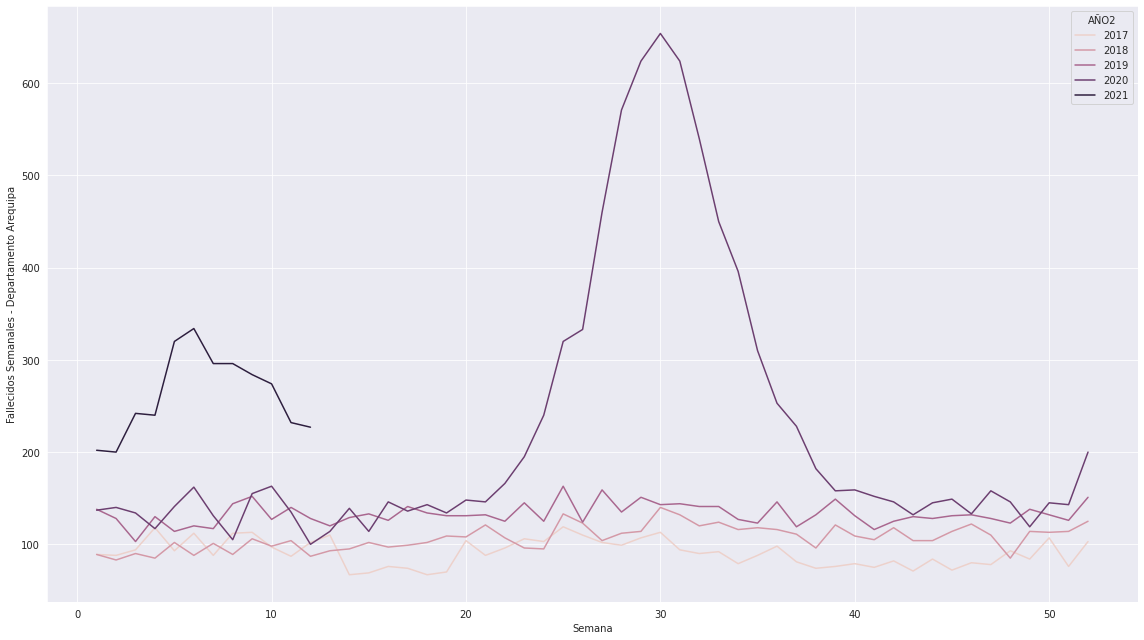

In [ ]:
fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(16, 9))

sns.lineplot(data=datos_sinadef_arequipa_semana, x = 'SEMANA', y = 'Nº', hue='AÑO2', ax=ax1)

plt.xlabel('Semana')
plt.ylabel('Fallecidos Semanales - Departamento Arequipa')
fig.tight_layout()

plt.show()

# Datos No Violentos

In [ ]:
datos_sinadef_no_violenta = datos_sinadef_raw[(datos_sinadef_raw['MUERTE VIOLENTA'] == 'SIN REGISTRO')]

# Visualizaciones Arequipa solo Covid

In [ ]:
datos_sinadef_no_violenta_arequipa = datos_sinadef_no_violenta[(datos_sinadef_no_violenta['FECHA'] >= '2020-01-01') & \
                                                                     (datos_sinadef_no_violenta['DEPARTAMENTO DOMICILIO'] == 'AREQUIPA')]

In [ ]:
datos_sinadef_no_violenta_arequipa_covid = datos_sinadef_no_violenta_arequipa[datos_sinadef_no_violenta_arequipa['FECHA'] <= '2021-03-24' ]
datos_sinadef_no_violenta_arequipa_covid = datos_sinadef_no_violenta_arequipa_covid[(datos_sinadef_no_violenta_arequipa_covid['CAUSA A (CIE-X)'] == 'U071') | (datos_sinadef_no_violenta_arequipa_covid['CAUSA B (CIE-X)'] == 'U071') | (datos_sinadef_no_violenta_arequipa_covid['CAUSA C (CIE-X)'] == 'U071') | (datos_sinadef_no_violenta_arequipa_covid['CAUSA D (CIE-X)'] == 'U071') | (datos_sinadef_no_violenta_arequipa_covid['CAUSA E (CIE-X)'] == 'U071') | (datos_sinadef_no_violenta_arequipa_covid['CAUSA F (CIE-X)'] == 'U071')]

datos_sinadef_no_violenta_arequipa_covid['SEMANA'] = datos_sinadef_no_violenta_arequipa_covid['SEMANA'].astype('str')
datos_sinadef_no_violenta_arequipa_covid['SEMANA'] = datos_sinadef_no_violenta_arequipa_covid['SEMANA'].apply(lambda x: '0'+x if len(x)==1 else x)
datos_sinadef_no_violenta_arequipa_covid['AÑOSEMANA'] = datos_sinadef_no_violenta_arequipa_covid['AÑO2'].astype('str') + '-' + datos_sinadef_no_violenta_arequipa_covid['SEMANA']

datos_sinadef_no_violenta_arequipa_covid.tail()

,Nº,TIPO SEGURO,SEXO,EDAD,TIEMPO EDAD,ESTADO CIVIL,NIVEL DE INSTRUCCIÓN,COD# UBIGEO DOMICILIO,PAIS DOMICILIO,DEPARTAMENTO DOMICILIO,PROVINCIA DOMICILIO,DISTRITO DOMICILIO,FECHA,AÑO,MES,TIPO LUGAR,INSTITUCION,MUERTE VIOLENTA,NECROPSIA,DEBIDO A (CAUSA A),CAUSA A (CIE-X),DEBIDO A (CAUSA B),CAUSA B (CIE-X),DEBIDO A (CAUSA C),CAUSA C (CIE-X),DEBIDO A (CAUSA D),CAUSA D (CIE-X),DEBIDO A (CAUSA E),CAUSA E (CIE-X),DEBIDO A (CAUSA F),CAUSA F (CIE-X),SEMANA,AÑOSEMANA,MESDIA,AÑO2
616387,616388,SIS,MASCULINO,54,AÑOS,SOLTERO,IGNORADO,92-33-04-01-07-000,PERU,AREQUIPA,AREQUIPA,MIRAFLORES,2021-03-01,2021,3,EESS,GOBIERNO REGIONAL,SIN REGISTRO,NO SE REALIZÓ NECROPSIA,INSUFICIENCIA RESPIRATORIA AGUDA,J960,NEUMONIA VIRAL,J129,INFECCION POR COVID 19,U071,SIN REGISTRO,SIN REGISTRO,OBESIDAD,E660,SIN REGISTRO,SIN REGISTRO,10,2021-10,03-01,2021
616452,616453,SANIDAD PNP,FEMENINO,84,AÑOS,VIUDO,IGNORADO,92-33-04-07-06-000,PERU,AREQUIPA,ISLAY,PUNTA DE BOMBON,2021-03-01,2021,3,EESS,SANIDAD DE LA POLICIA NACIONAL DEL PERU,SIN REGISTRO,NO SE REALIZÓ NECROPSIA,PARO CARDIORESPIRATORIO,I469,INFECCIÓN POR COVID,U071,DIABETES MELLITUS,E117,NEUMONIA POR COVID,J129,HIPERTENSIÓN ARTERIAL,I10X,SIN REGISTRO,SIN REGISTRO,10,2021-10,03-01,2021
616482,616483,SIS,MASCULINO,61,AÑOS,SOLTERO,IGNORADO,92-33-04-01-01-000,PERU,AREQUIPA,AREQUIPA,AREQUIPA,2021-03-01,2021,3,EESS,GOBIERNO REGIONAL,SIN REGISTRO,NO SE REALIZÓ NECROPSIA,INSUFICIENCIA RESPIRATORIA,J960,NEUMONIA POR SARS COV 2,U071,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,10,2021-10,03-01,2021
616501,616502,IGNORADO,FEMENINO,82,AÑOS,SOLTERO,IGNORADO,92-33-04-01-02-000,PERU,AREQUIPA,AREQUIPA,CAYMA,2021-03-01,2021,3,DOMICILIO,SIN REGISTRO,SIN REGISTRO,NO SE REALIZÓ NECROPSIA,INSUFICIENCIA RESPIRATORIA AGUDA SEVERA,J969,COVID 19 GRAVE,U071,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,10,2021-10,03-01,2021
616525,616526,ESSALUD,FEMENINO,78,AÑOS,CASADO,IGNORADO,92-33-04-01-29-000,PERU,AREQUIPA,AREQUIPA,JOSE LUIS BUSTAMANTE Y RIVERO,2021-03-01,2021,3,EESS,ESSALUD,SIN REGISTRO,NO SE REALIZÓ NECROPSIA,INSUFICIENCIA RESPIRATORIA AGUDA,J960,NEUMONIA SARS,J129,INFECCION POR SARS COV 2,U071,SIN REGISTRO,SIN REGISTRO,HIPERTENSION ARTERIAL,I10X,SIN REGISTRO,SIN REGISTRO,10,2021-10,03-01,2021


In [ ]:
datos_sinadef_no_violenta_arequipa_covid_semanal = datos_sinadef_no_violenta_arequipa_covid.groupby(['AÑOSEMANA'])['Nº'].count()
datos_sinadef_no_violenta_arequipa_covid_semanal = datos_sinadef_no_violenta_arequipa_covid_semanal.to_frame().reset_index()
datos_sinadef_no_violenta_arequipa_covid_semanal.tail()

,AÑOSEMANA,Nº
45,2021-09,123
46,2021-10,102
47,2021-11,85
48,2021-12,75
49,2021-13,30


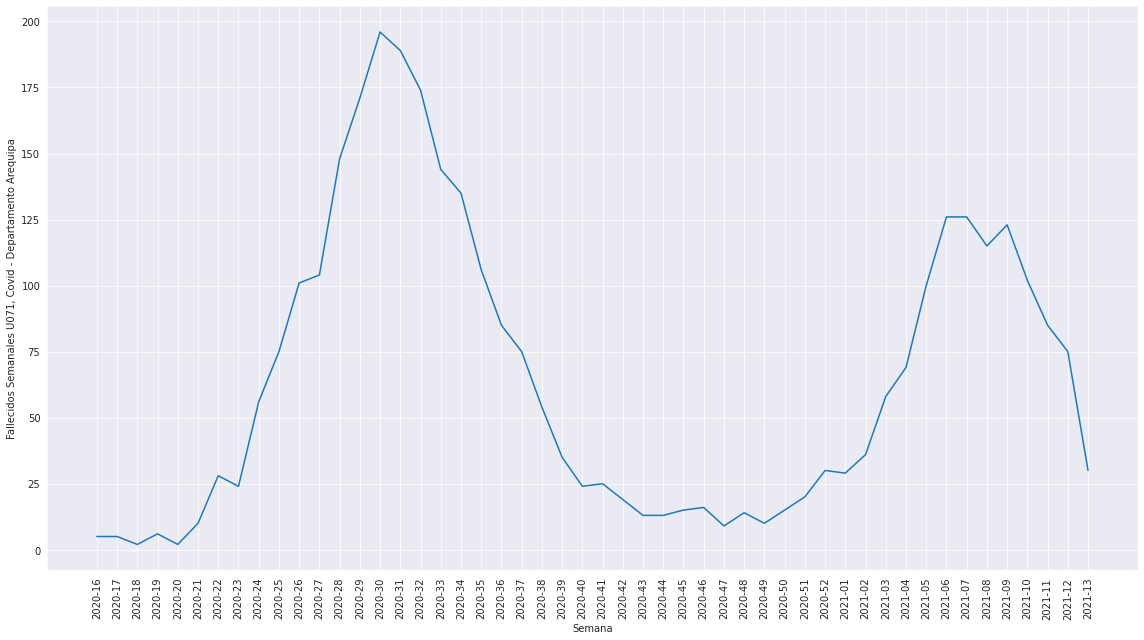

In [ ]:
fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(16, 9))

sns.lineplot(data=datos_sinadef_no_violenta_arequipa_covid_semanal, x = 'AÑOSEMANA', y = 'Nº', ax=ax1)

plt.xlabel('Semana')
plt.ylabel('Fallecidos Semanales U071, Covid - Departamento Arequipa')
plt.xticks(rotation=90)
fig.tight_layout()

plt.show()

In [ ]:
datos_sinadef_no_violenta_arequipa_covid_diaria = datos_sinadef_no_violenta_arequipa_covid.groupby(['FECHA'])['Nº'].count()
datos_sinadef_no_violenta_arequipa_covid_diaria = datos_sinadef_no_violenta_arequipa_covid_diaria.to_frame().reset_index()
datos_sinadef_no_violenta_arequipa_covid_diaria

,FECHA,Nº
0,2020-04-15,1
1,2020-04-17,1
2,2020-04-18,1
3,2020-04-19,2
4,2020-04-20,1
...,...,...
306,2021-03-20,7
307,2021-03-21,12
308,2021-03-22,15
309,2021-03-23,6


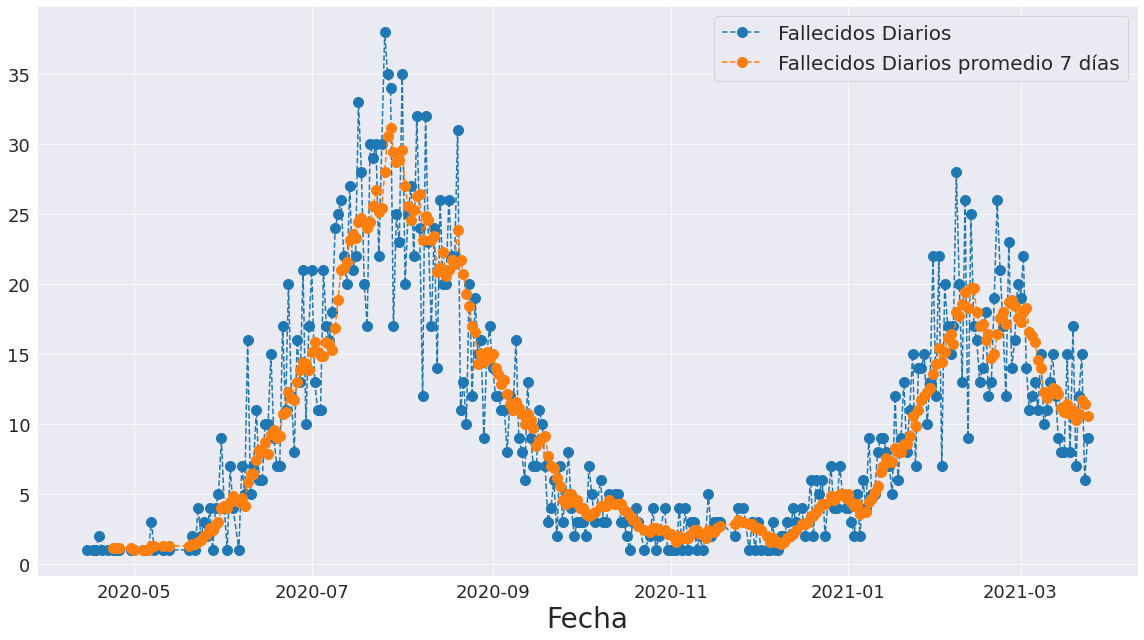

In [ ]:
datos_sinadef_no_violenta_arequipa_covid_diaria_aux = datos_sinadef_no_violenta_arequipa_covid_diaria
datos_sinadef_no_violenta_arequipa_covid_diaria_aux['FECHA'] = pd.to_datetime(datos_sinadef_no_violenta_arequipa_covid_diaria_aux['FECHA'])
datos_sinadef_no_violenta_arequipa_covid_diaria_aux = datos_sinadef_no_violenta_arequipa_covid_diaria_aux.set_index('FECHA')

fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(16, 9))

plots(ax1, 'line_plt', datos_sinadef_no_violenta_arequipa_covid_diaria_aux, 'Fecha', 'Fallecidos Diarios', 'Nº')
 
fig.tight_layout()
plt.show()

# Clustering datos No Violentos Arequipa

Reference: https://www.kaggle.com/maksimeren/covid-19-literature-clustering

In [ ]:
datos_sinadef_arequipa_clustering_sample = datos_sinadef_no_violenta[(datos_sinadef_no_violenta['FECHA'] >= '2020-01-01') & \
                                                                     (datos_sinadef_no_violenta['DEPARTAMENTO DOMICILIO'] == 'AREQUIPA')]

## Initialize

In [ ]:
# Download the spacy bio parser
from IPython.utils import io
with io.capture_output() as captured:
    !pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.2.4/en_core_sci_lg-0.2.4.tar.gz
    !pip install stop-words

#NLP 
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_sci_lg  # model downloaded in previous step
import string

from stop_words import get_stop_words

from tqdm import tqdm
tqdm.pandas()

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.decomposition import PCA

from sklearn.cluster import KMeans

from sklearn import metrics
from scipy.spatial.distance import cdist

from sklearn.manifold import TSNE

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [ ]:
stop_words = get_stop_words('spanish')
punctuations = string.punctuation

# Parser
parser = en_core_sci_lg.load(disable=["tagger", "ner"])
parser.max_length = 7000000

def spacy_tokenizer(sentence):
    mytokens = parser(sentence)
    #mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    mytokens = [ word.lemma_.lower().strip() for word in mytokens ]
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]
    mytokens = " ".join([i for i in mytokens])
    return mytokens

def vectorize(text, maxx_features):
    vectorizer = TfidfVectorizer(max_features=maxx_features)
    X = vectorizer.fit_transform(text)
    return X

# Functions for printing keywords for each topic
def selected_topics(model, vectorizer, top_n=3):
    current_words = []
    keywords = []
    
    for idx, topic in enumerate(model.components_):
        words = [(vectorizer.get_feature_names()[i], topic[i]) for i in topic.argsort()[:-top_n - 1:-1]]
        for word in words:
            if word[0] not in current_words:
                keywords.append(word)
                current_words.append(word[0])
                
    keywords.sort(key = lambda x: x[1])  
    keywords.reverse()
    return_values = []
    for ii in keywords:
        return_values.append(ii[0])
    return return_values

## Pre-processing

In [ ]:
datos_sinadef_arequipa_clustering_sample = datos_sinadef_arequipa_clustering_sample.replace('SIN REGISTRO', ' ')

datos_sinadef_arequipa_clustering_sample = datos_sinadef_arequipa_clustering_sample[['DEBIDO A (CAUSA A)',
                                                                                     'CAUSA A (CIE-X)',
                                                                                     'DEBIDO A (CAUSA B)',
                                                                                     'CAUSA B (CIE-X)',
                                                                                     'DEBIDO A (CAUSA C)',
                                                                                     'CAUSA C (CIE-X)',
                                                                                     'DEBIDO A (CAUSA D)',
                                                                                     'CAUSA D (CIE-X)',
                                                                                     'DEBIDO A (CAUSA E)',
                                                                                     'CAUSA E (CIE-X)',
                                                                                     'DEBIDO A (CAUSA F)',
                                                                                     'CAUSA F (CIE-X)']]

datos_sinadef_arequipa_clustering_sample['all_features'] =  datos_sinadef_arequipa_clustering_sample['DEBIDO A (CAUSA A)'] + ' ' + \
                                                            datos_sinadef_arequipa_clustering_sample['CAUSA A (CIE-X)'] + ' ' + \
                                                            datos_sinadef_arequipa_clustering_sample['DEBIDO A (CAUSA B)'] + ' ' + \
                                                            datos_sinadef_arequipa_clustering_sample['CAUSA B (CIE-X)'] + ' ' + \
                                                            datos_sinadef_arequipa_clustering_sample['DEBIDO A (CAUSA C)'] + ' ' + \
                                                            datos_sinadef_arequipa_clustering_sample['CAUSA C (CIE-X)'] + ' ' + \
                                                            datos_sinadef_arequipa_clustering_sample['DEBIDO A (CAUSA D)'] + ' ' + \
                                                            datos_sinadef_arequipa_clustering_sample['CAUSA D (CIE-X)'] + ' ' + \
                                                            datos_sinadef_arequipa_clustering_sample['DEBIDO A (CAUSA E)'] + ' ' + \
                                                            datos_sinadef_arequipa_clustering_sample['CAUSA E (CIE-X)'] + ' ' + \
                                                            datos_sinadef_arequipa_clustering_sample['DEBIDO A (CAUSA F)'] + ' ' + \
                                                            datos_sinadef_arequipa_clustering_sample['CAUSA F (CIE-X)']

datos_sinadef_arequipa_clustering_sample

,DEBIDO A (CAUSA A),CAUSA A (CIE-X),DEBIDO A (CAUSA B),CAUSA B (CIE-X),DEBIDO A (CAUSA C),CAUSA C (CIE-X),DEBIDO A (CAUSA D),CAUSA D (CIE-X),DEBIDO A (CAUSA E),CAUSA E (CIE-X),DEBIDO A (CAUSA F),CAUSA F (CIE-X),all_features
52,TRAUMATISMO ENCEFALO CRANEANO,S069,AHOGAMIENTO Y SUMERSIÓN EN RÍO,W698,,,,,,,,,TRAUMATISMO ENCEFALO CRANEANO S069 AHOGAMIENTO...
61,NEOPLASIA DE PANCREAS,,,,,,,,,,,,NEOPLASIA DE PANCREAS
170,IMPRECISABLE POR AVANZADO ESTADO DE DESCOMPOSI...,,,,,,,,,,,,IMPRECISABLE POR AVANZADO ESTADO DE DESCOMPOSI...
220,CHOQUE SEPTICO,R572,BRONCONEUMONIA,J180,ENFERMEDAD POR VIH,B207,,,,,,,CHOQUE SEPTICO R572 BRONCONEUMONIA J180 ENFERM...
226,INSUFICIENCIA RESPIRATORIA,,ENFERMEDAD DE MEMBRANA HIALINA,,RECIÉN NACIDO DE PARTO PRETÉRMINO,,,,,,,,INSUFICIENCIA RESPIRATORIA ENFERMEDAD DE MEM...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
616482,INSUFICIENCIA RESPIRATORIA,J960,NEUMONIA POR SARS COV 2,U071,,,,,,,,,INSUFICIENCIA RESPIRATORIA J960 NEUMONIA POR S...
616496,SENILIDAD,R54X,,,,,,,,,,,SENILIDAD R54X
616501,INSUFICIENCIA RESPIRATORIA AGUDA SEVERA,J969,COVID 19 GRAVE,U071,,,,,,,,,INSUFICIENCIA RESPIRATORIA AGUDA SEVERA J969 C...
616513,FALLA MULTIORGANICA,R688,NEOPLASIA DE RIÑON,C64X,,,,,,,,,FALLA MULTIORGANICA R688 NEOPLASIA DE RIÑON C6...


## Clean

In [ ]:
datos_sinadef_arequipa_clustering_sample["processed_text"] = datos_sinadef_arequipa_clustering_sample['all_features'].progress_apply(spacy_tokenizer)

100%|██████████| 14160/14160 [01:05<00:00, 215.33it/s]


## Vectorize

In [ ]:
text = datos_sinadef_arequipa_clustering_sample['processed_text'].values
X = vectorize(text, 2 ** 12)
X.shape

(14160, 4096)

## PCA

In [ ]:
pca = PCA(n_components=0.95, random_state=42)
X_reduced= pca.fit_transform(X.toarray())
X_reduced.shape

(14160, 1422)

## Elbow Method

In [ ]:
# run kmeans with many different k
"""
distortions = []
K = range(2, 50)
for k in K:
    k_means = KMeans(n_clusters=k, random_state=42).fit(X_reduced)
    k_means.fit(X_reduced)
    distortions.append(sum(np.min(cdist(X_reduced, k_means.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])
    print('Found distortion for {} clusters'.format(k))

X_line = [K[0], K[-1]]
Y_line = [distortions[0], distortions[-1]]

# Plot the elbow
plt.plot(K, distortions, 'b-')
plt.plot(X_line, Y_line, 'r')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.savefig('elbow_departamento_arequipa_2020.png')
plt.show()
"""

"\ndistortions = []\nK = range(2, 50)\nfor k in K:\n    k_means = KMeans(n_clusters=k, random_state=42).fit(X_reduced)\n    k_means.fit(X_reduced)\n    distortions.append(sum(np.min(cdist(X_reduced, k_means.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])\n    print('Found distortion for {} clusters'.format(k))\n\nX_line = [K[0], K[-1]]\nY_line = [distortions[0], distortions[-1]]\n\n# Plot the elbow\nplt.plot(K, distortions, 'b-')\nplt.plot(X_line, Y_line, 'r')\nplt.xlabel('k')\nplt.ylabel('Distortion')\nplt.title('The Elbow Method showing the optimal k')\nplt.savefig('elbow_departamento_arequipa_2020.png')\nplt.show()\n"

## K-means over K calculated

In [ ]:
k = 4
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(X_reduced)
datos_sinadef_arequipa_clustering_sample['y'] = y_pred

## TSNE Method

In [ ]:
tsne = TSNE(verbose=1, perplexity=100, random_state=42)
X_embedded = tsne.fit_transform(X.toarray())

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 14160 samples in 13.179s...
[t-SNE] Computed neighbors for 14160 samples in 1762.039s...
[t-SNE] Computed conditional probabilities for sample 1000 / 14160
[t-SNE] Computed conditional probabilities for sample 2000 / 14160
[t-SNE] Computed conditional probabilities for sample 3000 / 14160
[t-SNE] Computed conditional probabilities for sample 4000 / 14160
[t-SNE] Computed conditional probabilities for sample 5000 / 14160
[t-SNE] Computed conditional probabilities for sample 6000 / 14160
[t-SNE] Computed conditional probabilities for sample 7000 / 14160
[t-SNE] Computed conditional probabilities for sample 8000 / 14160
[t-SNE] Computed conditional probabilities for sample 9000 / 14160
[t-SNE] Computed conditional probabilities for sample 10000 / 14160
[t-SNE] Computed conditional probabilities for sample 11000 / 14160
[t-SNE] Computed conditional probabilities for sample 12000 / 14160
[t-SNE] Computed conditional probabilities fo

## Plot Clusters

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


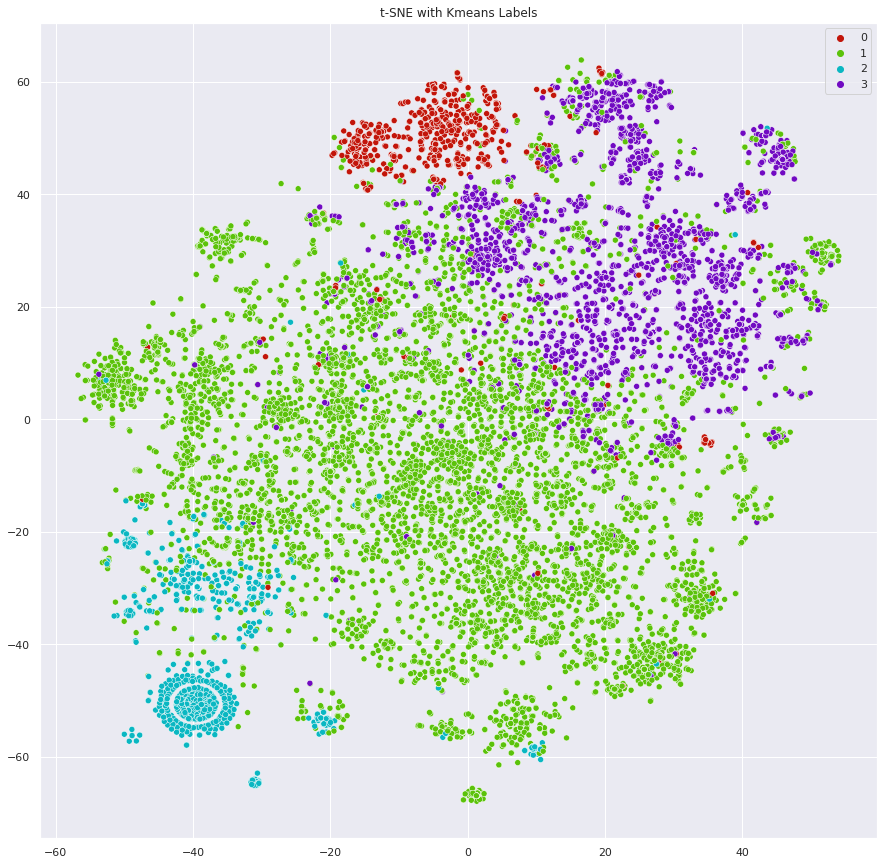

In [ ]:
# sns settings
sns.set(rc={'figure.figsize':(15,15)})

# colors
palette = sns.hls_palette(k, l=.4, s=.9)

# plot
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y_pred, legend='full', palette=palette)
plt.title('t-SNE with Kmeans Labels')
plt.savefig("image_23.png")
plt.show()

## Topic Modeling

In [ ]:
vectorizers = []
    
for ii in range(0, k):
    # Creating a vectorizer
    vectorizers.append(CountVectorizer(min_df=5, max_df=0.9, stop_words=stop_words, lowercase=True, token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}'))

vectorizers[0]

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=0.9, max_features=None, min_df=5,
                ngram_range=(1, 1), preprocessor=None,
                stop_words=['a', 'al', 'algo', 'algunas', 'algunos', 'ante',
                            'antes', 'como', 'con', 'contra', 'cual', 'cuando',
                            'de', 'del', 'desde', 'donde', 'durante', 'e', 'el',
                            'ella', 'ellas', 'ellos', 'en', 'entre', 'era',
                            'erais', 'eran', 'eras', 'eres', 'es', ...],
                strip_accents=None, token_pattern='[a-zA-Z\\-][a-zA-Z\\-]{2,}',
                tokenizer=None, vocabulary=None)

In [ ]:
vectorized_data = []

for current_cluster, cvec in enumerate(vectorizers):
    try:
        vectorized_data.append(cvec.fit_transform(datos_sinadef_arequipa_clustering_sample.loc[datos_sinadef_arequipa_clustering_sample['y'] == current_cluster, 'processed_text']))
    except Exception as e:
        print("Not enough instances in cluster: " + str(current_cluster))
        vectorized_data.append(None)
        
len(vectorized_data)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ais', 'amos', 'bamos', 'est', 'estuvi', 'hab', 'habr', 'hubi', 'ramos', 'semos', 'ser', 'tambi', 'ten', 'tendr', 'teng', 'tuvi'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ais', 'amos', 'bamos', 'est', 'estuvi', 'hab', 'habr', 'hubi', 'ramos', 'semos', 'ser', 'tambi', 'ten', 'tendr', 'teng', 'tuvi'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ais', 'amos', 'bamos', 'est', 

4

In [ ]:
# number of topics per cluster
NUM_TOPICS_PER_CLUSTER = 10

lda_models = []
for ii in range(0, k):
    # Latent Dirichlet Allocation Model
    lda = LatentDirichletAllocation(n_components=NUM_TOPICS_PER_CLUSTER, max_iter=10, learning_method='online',verbose=False, random_state=42)
    lda_models.append(lda)
    
lda_models[0]

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='online', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=10, n_jobs=None,
                          perp_tol=0.1, random_state=42, topic_word_prior=None,
                          total_samples=1000000.0, verbose=False)

In [ ]:
clusters_lda_data = []

for current_cluster, lda in enumerate(lda_models):
    print("Current Cluster: " + str(current_cluster))
    
    if vectorized_data[current_cluster] != None:
        clusters_lda_data.append((lda.fit_transform(vectorized_data[current_cluster])))

len(clusters_lda_data[0])

Current Cluster: 0
Current Cluster: 1
Current Cluster: 2
Current Cluster: 3


859

In [ ]:
all_keywords = []
for current_vectorizer, lda in enumerate(lda_models):
    # print("Current Cluster: " + str(current_vectorizer))

    if vectorized_data[current_vectorizer] != None:
        all_keywords.append(selected_topics(lda, vectorizers[current_vectorizer]))

display(all_keywords[2][:20])
len(all_keywords)

['choque',
 'cardiogenico',
 'multiorganica',
 'diabetes',
 'mellitus',
 'insuficiencia',
 'arterial',
 'respiratoria',
 'cardiopatia',
 'hipertension',
 'falla',
 'shock',
 'mellituns',
 'aguda',
 'paro',
 'cronica',
 'respiratorio',
 'cardio',
 'sepsis',
 'isquemica']

4

In [ ]:
f=open('topicos.txt','w')

count = 0

for ii in all_keywords:

    if vectorized_data[count] != None:
        f.write(', '.join(ii) + "\n")
    else:
        f.write("Not enough instances to be determined. \n")
        f.write(', '.join(ii) + "\n")
    count += 1

f.close()

## Verifying Topics

In [ ]:
ver_topico = 3
df = datos_sinadef_arequipa_clustering_sample[datos_sinadef_arequipa_clustering_sample['y'] == ver_topico]
display(df)

df.to_csv('df.csv')

df['processed_text'].to_csv('palabras_cluster_' + str(ver_topico) + '.txt', header=False, index=False)

from collections import Counter
results = Counter()
df['processed_text'].str.lower().str.split().apply(results.update)
print(results)

,DEBIDO A (CAUSA A),CAUSA A (CIE-X),DEBIDO A (CAUSA B),CAUSA B (CIE-X),DEBIDO A (CAUSA C),CAUSA C (CIE-X),DEBIDO A (CAUSA D),CAUSA D (CIE-X),DEBIDO A (CAUSA E),CAUSA E (CIE-X),DEBIDO A (CAUSA F),CAUSA F (CIE-X),all_features,processed_text,y
3229,INSUFICIENCIA RESPIRATORIA AGUDA,,NEUMONIA,,,,,,,,,,INSUFICIENCIA RESPIRATORIA AGUDA NEUMONIA ...,insuficiencia respiratoria aguda neumonia,3
6314,INSUFICIENCIA RESPIRATORIA AGUDA,J960,NEUMONIA,J189,,,,,,,,,INSUFICIENCIA RESPIRATORIA AGUDA J960 NEUMONIA...,insuficiencia respiratoria aguda j960 neumonia...,3
7843,INSUFICIENCIA RESPIRATORIA AGUDA,J960,NEUMONIA,J189,,,,,,,,,INSUFICIENCIA RESPIRATORIA AGUDA J960 NEUMONIA...,insuficiencia respiratoria aguda j960 neumonia...,3
9914,INSUFICIENCIA RESPIRATORIA,J960,NEUMONIA,J159,,,,,,,,,INSUFICIENCIA RESPIRATORIA J960 NEUMONIA J159 ...,insuficiencia respiratoria j960 neumonia j159,3
10770,INSUFICIENCIA RESPIRATORIA,,NEUMONIA,,,,,,,,,,INSUFICIENCIA RESPIRATORIA NEUMONIA ...,insuficiencia respiratoria neumonia,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
616225,SINDROME DE DIFICULTAD RESPIRATORIA DEL ADULTO,J80X,INSUFICIENCIA RESPIRATORIA NO ESPECIFICADA,J969,NEUMONIA NO ESPECIFICADA,J189,COVID-19 VIRUS IDENTIFICADO,U071,,,,,SINDROME DE DIFICULTAD RESPIRATORIA DEL ADULTO...,sindrome dificultad respiratoria adulto j80x i...,3
616279,INSUFICIENCIA RESPIRATORIA AGUDA,J960,NEUMONIA VIRAL,J129,COVID 19 VIRUS IDENTIFICADO,U071,,,,,,,INSUFICIENCIA RESPIRATORIA AGUDA J960 NEUMONIA...,insuficiencia respiratoria aguda j960 neumonia...,3
616337,INSUFICIENCIA RESPIRATORIA AGUDA,J960,NEUMONIA,J189,CORONAVIRUS-COVI 19,U071,,,,,,,INSUFICIENCIA RESPIRATORIA AGUDA J960 NEUMONIA...,insuficiencia respiratoria aguda j960 neumonia...,3
616387,INSUFICIENCIA RESPIRATORIA AGUDA,J960,NEUMONIA VIRAL,J129,INFECCION POR COVID 19,U071,,,OBESIDAD,E660,,,INSUFICIENCIA RESPIRATORIA AGUDA J960 NEUMONIA...,insuficiencia respiratoria aguda j960 neumonia...,3


Counter({'respiratoria': 3444, 'insuficiencia': 3107, 'covid': 2731, 'neumonia': 2322, 'j960': 2232, 'u071': 2221, '19': 2169, 'aguda': 1963, 'virus': 1049, 'identificado': 1041, 'u072': 961, 'viral': 723, 'j80x': 595, 'j129': 522, 'j969': 514, 'severa': 488, 'infeccion': 488, 'j189': 436, 'covid-19': 404, 'dificultad': 390, 'sindrome': 385, 'arterial': 315, 'i10x': 308, 'hipertension': 295, 'especificada': 289, 'atipica': 284, 'adulto': 266, 'diabetes': 251, 'j128': 247, 'mellitus': 245, 'obesidad': 221, 'covid19': 206, 'j22x': 201, 'falla': 191, 'coronavirus': 179, 'caso': 174, 'e669': 164, 'sospechoso': 156, 'infección': 130, 'renal': 127, 'neumonía': 123, 'multiorganica': 120, 'enfermedad': 106, 'shock': 106, 'confirmado': 105, 'respiratorio': 99, 'e119': 84, 'r579': 84, 'sepsis': 79, '2': 78, 'pulmonar': 77, 'a419': 71, 'j180': 68, 'síndrome': 67, 'n179': 65, 'b972': 64, 'septico': 63, 'j168': 60, 'j159': 59, 'r651': 55, 'tipo': 50, 'choque': 46, 'r572': 45, 'distres': 45, 'cronic

## Visualize only Covid-19 with topics

In [ ]:
datos_sinadef_arequipa_clustering_sample_2 = datos_sinadef_no_violenta[(datos_sinadef_no_violenta['FECHA'] >= '2020-01-01') & \
                                                                     (datos_sinadef_no_violenta['DEPARTAMENTO DOMICILIO'] == 'AREQUIPA')]
datos_sinadef_arequipa_clustering_sample_2['TOPICO'] = datos_sinadef_arequipa_clustering_sample['y']
datos_sinadef_arequipa_clustering_sample_2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Nº,TIPO SEGURO,SEXO,EDAD,TIEMPO EDAD,ESTADO CIVIL,NIVEL DE INSTRUCCIÓN,COD# UBIGEO DOMICILIO,PAIS DOMICILIO,DEPARTAMENTO DOMICILIO,PROVINCIA DOMICILIO,DISTRITO DOMICILIO,FECHA,AÑO,MES,TIPO LUGAR,INSTITUCION,MUERTE VIOLENTA,NECROPSIA,DEBIDO A (CAUSA A),CAUSA A (CIE-X),DEBIDO A (CAUSA B),CAUSA B (CIE-X),DEBIDO A (CAUSA C),CAUSA C (CIE-X),DEBIDO A (CAUSA D),CAUSA D (CIE-X),DEBIDO A (CAUSA E),CAUSA E (CIE-X),DEBIDO A (CAUSA F),CAUSA F (CIE-X),SEMANA,AÑOSEMANA,MESDIA,AÑO2,TOPICO
52,53,SIS,FEMENINO,2,AÑOS,SOLTERO,NINGUN NIVEL / ILETRADO,92-33-04-08-04-000,PERU,AREQUIPA,LA UNION,HUAYNACOTAS,2020-01-15,2020,1,OTRO,SIN REGISTRO,SIN REGISTRO,NO SE REALIZÓ NECROPSIA,TRAUMATISMO ENCEFALO CRANEANO,S069,AHOGAMIENTO Y SUMERSIÓN EN RÍO,W698,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,3,2020-3,01-15,2020,1
61,62,ESSALUD,MASCULINO,88,AÑOS,CASADO,PRIMARIA COMPLETA,92-33-04-01-09-000,PERU,AREQUIPA,AREQUIPA,PAUCARPATA,2020-01-16,2020,1,DOMICILIO,SIN REGISTRO,SIN REGISTRO,NO SE REALIZÓ NECROPSIA,NEOPLASIA DE PANCREAS,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,3,2020-3,01-16,2020,1
170,171,SIS,MASCULINO,60,AÑOS,SOLTERO,SECUNDARIA COMPLETA,92-33-04-01-28-000,PERU,AREQUIPA,AREQUIPA,ALTO SELVA ALEGRE,2020-01-28,2020,1,DOMICILIO,SIN REGISTRO,SIN REGISTRO,SI SE REALIZÓ NECROPSIA,IMPRECISABLE POR AVANZADO ESTADO DE DESCOMPOSI...,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,5,2020-5,01-28,2020,1
220,221,SIS,MASCULINO,57,AÑOS,SOLTERO,SECUNDARIA COMPLETA,92-33-04-01-27-000,PERU,AREQUIPA,AREQUIPA,JACOBO HUNTER,2020-02-01,2020,2,EESS,GOBIERNO REGIONAL,SIN REGISTRO,NO SE REALIZÓ NECROPSIA,CHOQUE SEPTICO,R572,BRONCONEUMONIA,J180,ENFERMEDAD POR VIH,B207,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,5,2020-5,02-01,2020,1
226,227,SIS,MASCULINO,5,DIAS,SOLTERO,NINGUN NIVEL / ILETRADO,92-33-04-01-26-000,PERU,AREQUIPA,AREQUIPA,MARIANO MELGAR,2020-01-31,2020,1,EESS,GOBIERNO REGIONAL,SIN REGISTRO,NO SE REALIZÓ NECROPSIA,INSUFICIENCIA RESPIRATORIA,SIN REGISTRO,ENFERMEDAD DE MEMBRANA HIALINA,SIN REGISTRO,RECIÉN NACIDO DE PARTO PRETÉRMINO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,5,2020-5,01-31,2020,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
616482,616483,SIS,MASCULINO,61,AÑOS,SOLTERO,IGNORADO,92-33-04-01-01-000,PERU,AREQUIPA,AREQUIPA,AREQUIPA,2021-03-01,2021,3,EESS,GOBIERNO REGIONAL,SIN REGISTRO,NO SE REALIZÓ NECROPSIA,INSUFICIENCIA RESPIRATORIA,J960,NEUMONIA POR SARS COV 2,U071,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,10,2021-10,03-01,2021,0
616496,616497,IGNORADO,FEMENINO,92,AÑOS,CASADO,PRIMARIA COMPLETA,92-33-04-01-26-000,PERU,AREQUIPA,AREQUIPA,MARIANO MELGAR,2021-03-01,2021,3,DOMICILIO,SIN REGISTRO,SIN REGISTRO,NO SE REALIZÓ NECROPSIA,SENILIDAD,R54X,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,10,2021-10,03-01,2021,1
616501,616502,IGNORADO,FEMENINO,82,AÑOS,SOLTERO,IGNORADO,92-33-04-01-02-000,PERU,AREQUIPA,AREQUIPA,CAYMA,2021-03-01,2021,3,DOMICILIO,SIN REGISTRO,SIN REGISTRO,NO SE REALIZÓ NECROPSIA,INSUFICIENCIA RESPIRATORIA AGUDA SEVERA,J969,COVID 19 GRAVE,U071,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,10,2021-10,03-01,2021,3
616513,616514,IGNORADO,FEMENINO,75,AÑOS,CASADO,PRIMARIA INCOMPLETA,92-33-04-01-03-000,PERU,AREQUIPA,AREQUIPA,CERRO COLORADO,2021-03-01,2021,3,DOMICILIO,SIN REGISTRO,SIN REGISTRO,NO SE REALIZÓ NECROPSIA,FALLA MULTIORGANICA,R688,NEOPLASIA DE RIÑON,C64X,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SI

In [ ]:
datos_sinadef_arequipa_clustering_sample_2.to_csv('datos_sinadef_arequipa_clustering_sample_2.csv')
#datos_sinadef_arequipa_clustering_sample_2 = pd.read_csv('datos_sinadef_arequipa_clustering_sample_2.csv')
datos_sinadef_arequipa_clustering_sample_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14160 entries, 52 to 616525
Data columns (total 36 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Nº                      14160 non-null  int64 
 1   TIPO SEGURO             14160 non-null  object
 2   SEXO                    14160 non-null  object
 3   EDAD                    14160 non-null  object
 4   TIEMPO EDAD             14160 non-null  object
 5   ESTADO CIVIL            14160 non-null  object
 6   NIVEL DE INSTRUCCIÓN    14160 non-null  object
 7   COD# UBIGEO DOMICILIO   14160 non-null  object
 8   PAIS DOMICILIO          14160 non-null  object
 9   DEPARTAMENTO DOMICILIO  14160 non-null  object
 10  PROVINCIA DOMICILIO     14160 non-null  object
 11  DISTRITO DOMICILIO      14160 non-null  object
 12  FECHA                   14160 non-null  object
 13  AÑO                     14160 non-null  int64 
 14  MES                     14160 non-null  int64 
 15  

In [ ]:
datos_sinadef_arequipa_clustering_sample_3 = datos_sinadef_arequipa_clustering_sample_2[datos_sinadef_arequipa_clustering_sample_2['FECHA'] <= '2021-03-24' ]
datos_sinadef_arequipa_clustering_sample_3 = datos_sinadef_arequipa_clustering_sample_3[(datos_sinadef_arequipa_clustering_sample_3['TOPICO'] == 0) | (datos_sinadef_arequipa_clustering_sample_3['TOPICO'] == 3)]

datos_sinadef_arequipa_clustering_sample_3['SEMANA'] = datos_sinadef_arequipa_clustering_sample_3['SEMANA'].astype('str')
datos_sinadef_arequipa_clustering_sample_3['SEMANA'] = datos_sinadef_arequipa_clustering_sample_3['SEMANA'].apply(lambda x: '0'+x if len(x)==1 else x)
datos_sinadef_arequipa_clustering_sample_3['AÑOSEMANA'] = datos_sinadef_arequipa_clustering_sample_3['AÑO2'].astype('str') + '-' + datos_sinadef_arequipa_clustering_sample_3['SEMANA']

datos_sinadef_arequipa_clustering_sample_3.tail()

,Nº,TIPO SEGURO,SEXO,EDAD,TIEMPO EDAD,ESTADO CIVIL,NIVEL DE INSTRUCCIÓN,COD# UBIGEO DOMICILIO,PAIS DOMICILIO,DEPARTAMENTO DOMICILIO,PROVINCIA DOMICILIO,DISTRITO DOMICILIO,FECHA,AÑO,MES,TIPO LUGAR,INSTITUCION,MUERTE VIOLENTA,NECROPSIA,DEBIDO A (CAUSA A),CAUSA A (CIE-X),DEBIDO A (CAUSA B),CAUSA B (CIE-X),DEBIDO A (CAUSA C),CAUSA C (CIE-X),DEBIDO A (CAUSA D),CAUSA D (CIE-X),DEBIDO A (CAUSA E),CAUSA E (CIE-X),DEBIDO A (CAUSA F),CAUSA F (CIE-X),SEMANA,AÑOSEMANA,MESDIA,AÑO2,TOPICO
616337,616338,SIS,MASCULINO,87,AÑOS,CASADO,PRIMARIA COMPLETA,92-33-04-02-20-000,PERU,AREQUIPA,CAYLLOMA,MAJES,2021-03-01,2021,3,EESS,GOBIERNO REGIONAL,SIN REGISTRO,NO SE REALIZÓ NECROPSIA,INSUFICIENCIA RESPIRATORIA AGUDA,J960,NEUMONIA,J189,CORONAVIRUS-COVI 19,U071,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,10,2021-10,03-01,2021,3
616387,616388,SIS,MASCULINO,54,AÑOS,SOLTERO,IGNORADO,92-33-04-01-07-000,PERU,AREQUIPA,AREQUIPA,MIRAFLORES,2021-03-01,2021,3,EESS,GOBIERNO REGIONAL,SIN REGISTRO,NO SE REALIZÓ NECROPSIA,INSUFICIENCIA RESPIRATORIA AGUDA,J960,NEUMONIA VIRAL,J129,INFECCION POR COVID 19,U071,SIN REGISTRO,SIN REGISTRO,OBESIDAD,E660,SIN REGISTRO,SIN REGISTRO,10,2021-10,03-01,2021,3
616482,616483,SIS,MASCULINO,61,AÑOS,SOLTERO,IGNORADO,92-33-04-01-01-000,PERU,AREQUIPA,AREQUIPA,AREQUIPA,2021-03-01,2021,3,EESS,GOBIERNO REGIONAL,SIN REGISTRO,NO SE REALIZÓ NECROPSIA,INSUFICIENCIA RESPIRATORIA,J960,NEUMONIA POR SARS COV 2,U071,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,10,2021-10,03-01,2021,0
616501,616502,IGNORADO,FEMENINO,82,AÑOS,SOLTERO,IGNORADO,92-33-04-01-02-000,PERU,AREQUIPA,AREQUIPA,CAYMA,2021-03-01,2021,3,DOMICILIO,SIN REGISTRO,SIN REGISTRO,NO SE REALIZÓ NECROPSIA,INSUFICIENCIA RESPIRATORIA AGUDA SEVERA,J969,COVID 19 GRAVE,U071,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,10,2021-10,03-01,2021,3
616525,616526,ESSALUD,FEMENINO,78,AÑOS,CASADO,IGNORADO,92-33-04-01-29-000,PERU,AREQUIPA,AREQUIPA,JOSE LUIS BUSTAMANTE Y RIVERO,2021-03-01,2021,3,EESS,ESSALUD,SIN REGISTRO,NO SE REALIZÓ NECROPSIA,INSUFICIENCIA RESPIRATORIA AGUDA,J960,NEUMONIA SARS,J129,INFECCION POR SARS COV 2,U071,SIN REGISTRO,SIN REGISTRO,HIPERTENSION ARTERIAL,I10X,SIN REGISTRO,SIN REGISTRO,10,2021-10,03-01,2021,0


In [ ]:
datos_sinadef_arequipa_clustering_sample_3_semanal = datos_sinadef_arequipa_clustering_sample_3.groupby(['AÑOSEMANA'])['Nº'].count()
datos_sinadef_arequipa_clustering_sample_3_semanal = datos_sinadef_arequipa_clustering_sample_3_semanal.to_frame().reset_index()
datos_sinadef_arequipa_clustering_sample_3_semanal.tail()

,AÑOSEMANA,Nº
54,2021-09,126
55,2021-10,106
56,2021-11,90
57,2021-12,78
58,2021-13,29


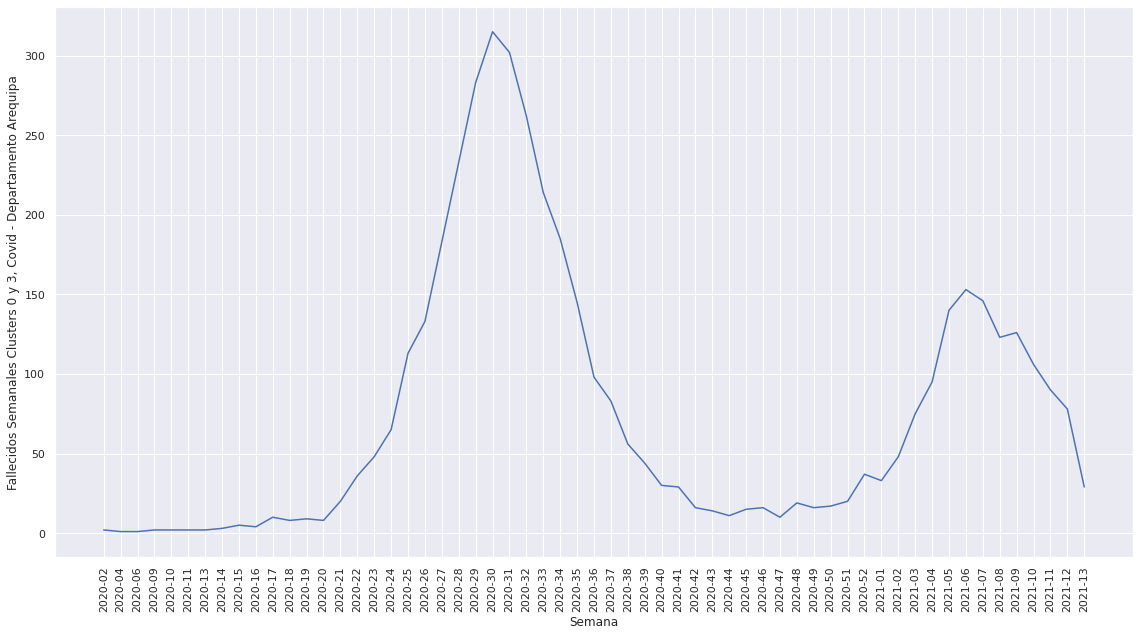

In [ ]:
fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(16, 9))

#sns.lineplot(data=datos_sinadef_arequipa_clustering_sample_3, x = 'SEMANA', y = 'Nº', hue='AÑO2', ax=ax1)
sns.lineplot(data=datos_sinadef_arequipa_clustering_sample_3_semanal, x = 'AÑOSEMANA', y = 'Nº', ax=ax1)

plt.xlabel('Semana')
plt.ylabel('Fallecidos Semanales Clusters 0 y 3, Covid - Departamento Arequipa')
plt.xticks(rotation=90)
fig.tight_layout()
plt.savefig('image_31.png')
plt.show()

In [ ]:
datos_sinadef_arequipa_clustering_sample_3_diaria = datos_sinadef_arequipa_clustering_sample_2.groupby(['FECHA'])['Nº'].count()
datos_sinadef_arequipa_clustering_sample_3_diaria = datos_sinadef_arequipa_clustering_sample_3_diaria.to_frame().reset_index()
datos_sinadef_arequipa_clustering_sample_3_diaria.tail()

,FECHA,Nº
445,2021-03-21,28
446,2021-03-22,34
447,2021-03-23,31
448,2021-03-24,23
449,2021-03-25,29


In [ ]:
"""
fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(16, 9))

sns.lineplot(data=datos_sinadef_arequipa_clustering_sample_3_diaria, x = 'FECHA', y = 'Nº', ax=ax1)

plt.xlabel('Semana')
plt.ylabel('Fallecidos Diarios Clusters 0 y 3, Covid - Departamento Arequipa')
plt.xticks(rotation=90)
fig.tight_layout()

plt.show()
"""

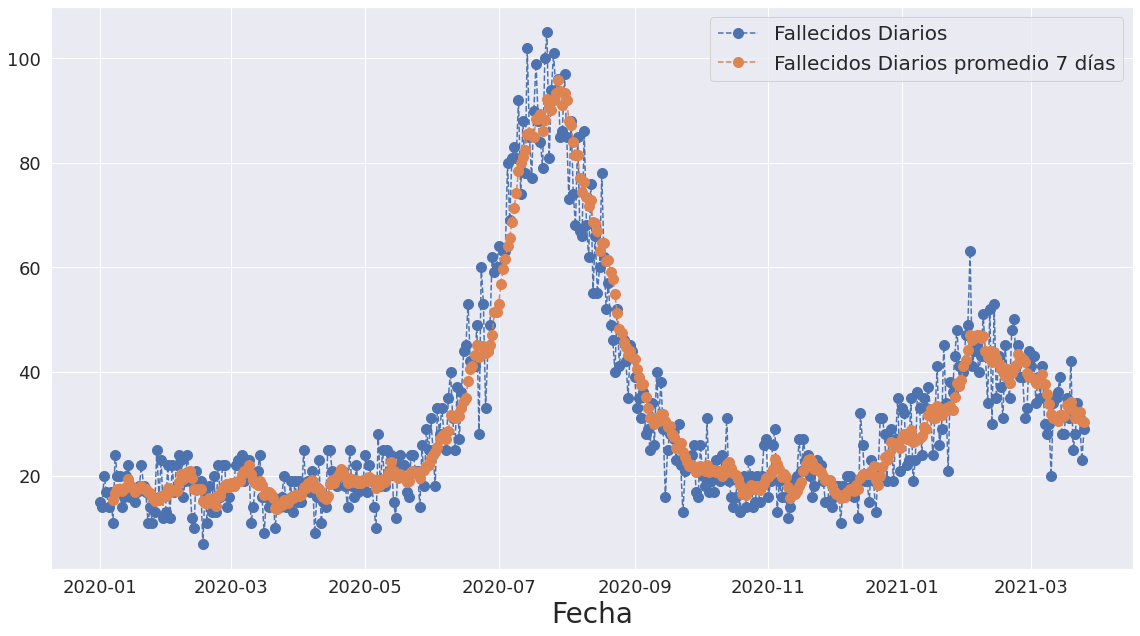

In [ ]:
datos_sinadef_arequipa_clustering_sample_3_diaria_aux = datos_sinadef_arequipa_clustering_sample_3_diaria
datos_sinadef_arequipa_clustering_sample_3_diaria_aux['FECHA'] = pd.to_datetime(datos_sinadef_arequipa_clustering_sample_3_diaria_aux['FECHA'])
datos_sinadef_arequipa_clustering_sample_3_diaria_aux = datos_sinadef_arequipa_clustering_sample_3_diaria.set_index('FECHA')

fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(16, 9))

plots(ax1, 'line_plt', datos_sinadef_arequipa_clustering_sample_3_diaria_aux, 'Fecha', 'Fallecidos Diarios', 'Nº')
 
fig.tight_layout()
plt.show()

In [ ]:
from google.colab import files
for i in range(1,26):
    files.download('image_' + str(i) + '.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>